# Project Solar

In [2]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation

## Data Verkenning

### Zonnepanelen dataset

#### Importeren en visualisatie

In [90]:
power = pd.read_csv('https://raw.githubusercontent.com/HOGENT-ML/course/main/datasets/solar.csv')
power

,timestamp,kwh
0,2023-03-11 16:00:10.160454+01,0.5400
1,2023-03-11 17:00:10.217795+01,1.0200
2,2023-03-11 18:00:10.284064+01,1.1700
3,2023-03-11 19:00:10.224836+01,1.1800
4,2023-03-11 20:00:10.201847+01,1.1800
...,...,...
9700,2024-04-19 06:00:10.326636+02,2417.3321
9701,2024-04-19 07:00:10.424826+02,2417.3321
9702,2024-04-19 08:00:10.360449+02,2417.3336
9703,2024-04-19 09:00:10.437154+02,2417.3701


In [91]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  9705 non-null   object 
 1   kwh        9705 non-null   float64
dtypes: float64(1), object(1)
memory usage: 151.8+ KB


In [92]:
power['timestamp'] = pd.to_datetime(power['timestamp'], utc=True)

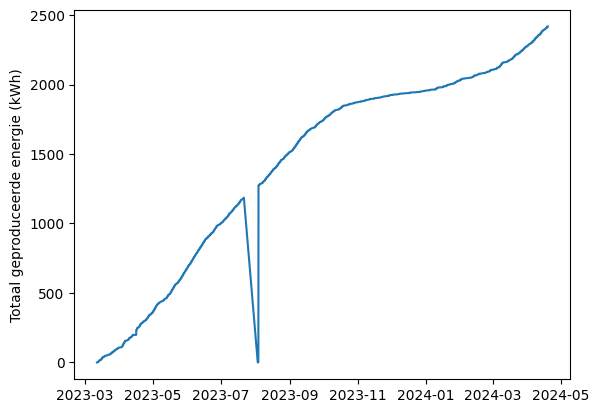

In [93]:
plt.plot(power['timestamp'], power['kwh'])
plt.ylabel('Totaal geproduceerde energie (kWh)')
plt.show()

We zien dat de kwh een cumulatieve meting is, de curve is monotoon stijgend. Er blijkt wel iets misgelopen te zijn in augustus 2023.

#### Onderzoek anomalie

In [94]:
power['kwh_per_hour'] = power['kwh'].diff().fillna(0)

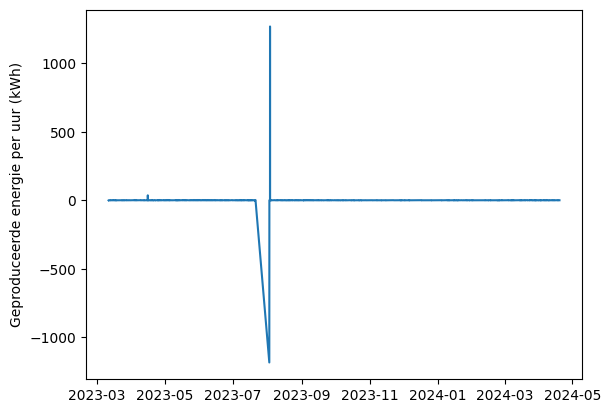

In [95]:
plt.plot(power['timestamp'], power['kwh_per_hour'])
plt.ylabel('Geproduceerde energie per uur (kWh)')
plt.show()

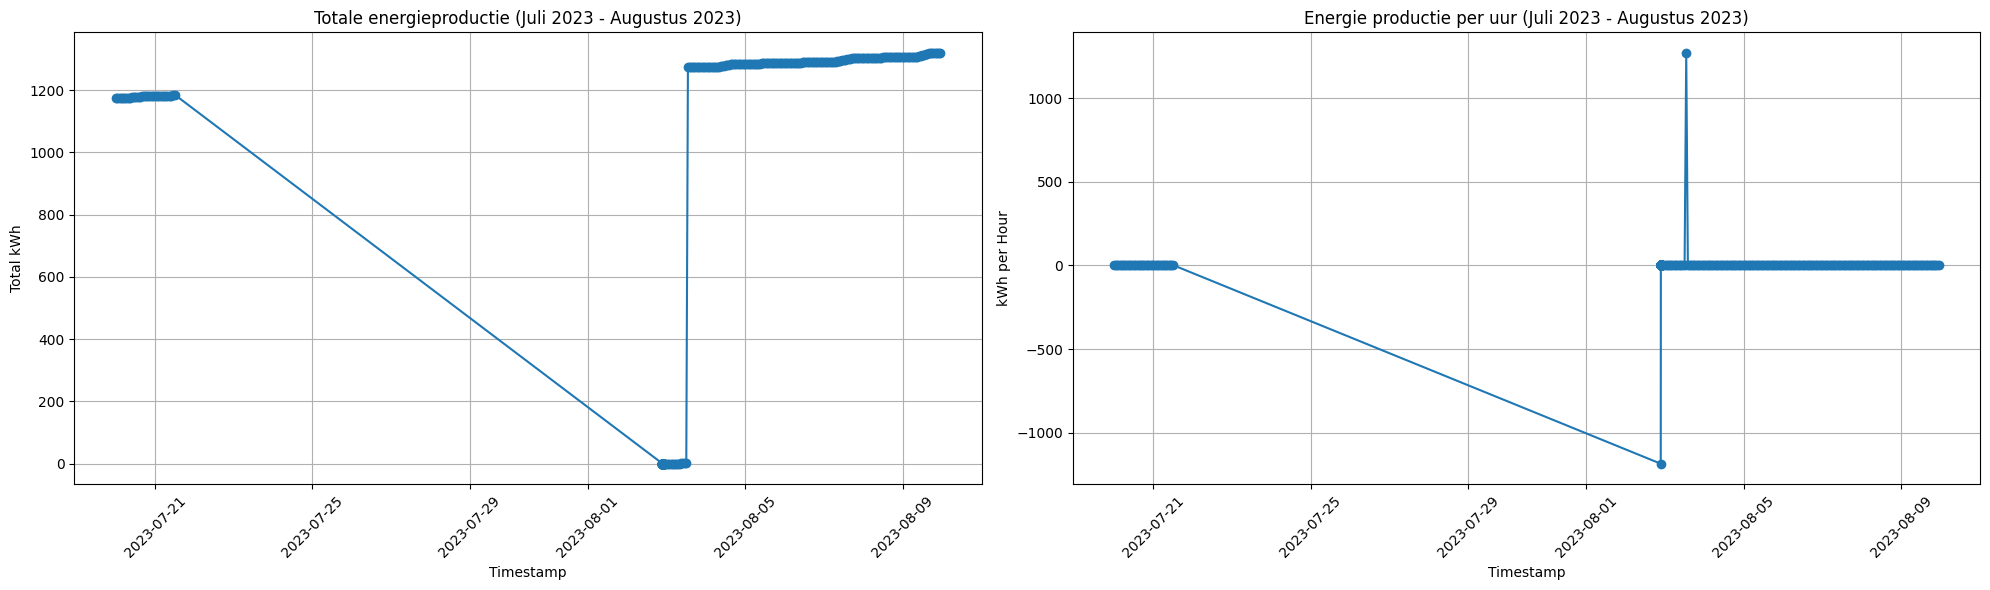

In [96]:
# Define the date range
start_date = pd.Timestamp('2023-07-20', tz='UTC')
end_date = pd.Timestamp('2023-08-10', tz='UTC')

power_augustus = power[(power['timestamp'] >= start_date) & (power['timestamp'] < end_date)]

# Create a figure with two subplots next to each other
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

# Plot total energy production
axes[0].plot(power_augustus['timestamp'], power_augustus['kwh'], marker='o', linestyle='-')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Total kWh')
axes[0].set_title('Totale energieproductie (Juli 2023 - Augustus 2023)')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Plot hourly energy production
axes[1].plot(power_augustus['timestamp'], power_augustus['kwh_per_hour'], marker='o', linestyle='-')
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('kWh per Hour')
axes[1].set_title('Energie productie per uur (Juli 2023 - Augustus 2023)')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In de figuur is te zien dat er heel wat waarden ontbreken tussen eind juli en begin augustus. Vervolgens zien we rond 3 augustus dat er gedurende een paar uur de totale energieproductie tot dat punt rond de nul hangt tot het op 1 uur tijd gecorrigeert wordt.

In [97]:
end_of_july = pd.Timestamp('2023-07-31 23:59:59', tz='UTC')
july_data = power[(power['timestamp'] >= start_date) & (power['timestamp'] <= end_of_july)]
last_timestamp_july = july_data['timestamp'].max()
print("Last timestamp in July before the blackout:", last_timestamp_july)

Last timestamp in July before the blackout: 2023-07-21 12:00:11.423424+00:00


In [98]:
power_correcties = power[abs(power['kwh_per_hour']) > 100]
power_correcties

,timestamp,kwh,kwh_per_hour
3166,2023-08-02 21:27:27.552237+00:00,0.0000,-1185.1582
3478,2023-08-03 13:00:12.358859+00:00,1272.9856,1269.9656


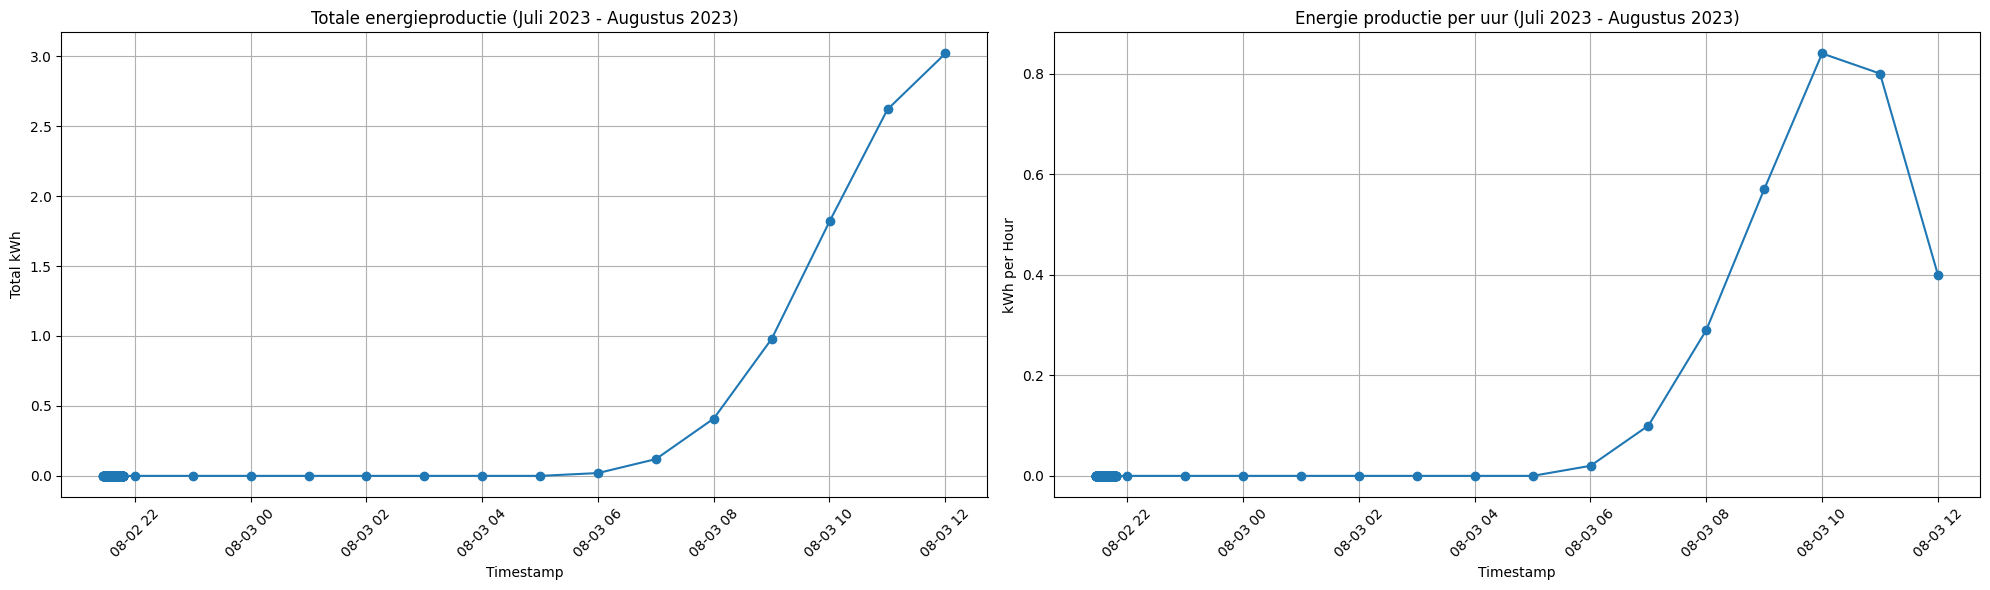

In [99]:
power_anomalie = power[(power['timestamp'] > power_correcties['timestamp'].iloc[0]) & (power['timestamp'] < power_correcties['timestamp'].iloc[-1])]

# Create a figure with two subplots next to each other
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

# Plot total energy production
axes[0].plot(power_anomalie['timestamp'], power_anomalie['kwh'], marker='o', linestyle='-')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Total kWh')
axes[0].set_title('Totale energieproductie (Juli 2023 - Augustus 2023)')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Plot hourly energy production
axes[1].plot(power_anomalie['timestamp'], power_anomalie['kwh_per_hour'], marker='o', linestyle='-')
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('kWh per Hour')
axes[1].set_title('Energie productie per uur (Juli 2023 - Augustus 2023)')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Het ziet ernaar uit dat de installatie gestopt is met het registreren van de power input op 2023-07-21 12:00:11.423424+00:00. Op 2023-08-02 21:27:27.552237+00:00, start de installatie terug op en wordt de totale energie productie op 0 gezet. Vervolgens werkt alles normaal voor een paar uur tot op 2023-08-03 13:00:12.358859+00:00 een correctie uitgevoerd wordt naar het echte niveau van de totale energie productie.

#### Opkuisen van data

In [100]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   timestamp     9705 non-null   datetime64[ns, UTC]
 1   kwh           9705 non-null   float64            
 2   kwh_per_hour  9705 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 227.6 KB


In [101]:
# Foute metingen verwijderen
power_filtered = power[(power['kwh_per_hour'] >= 0) & (power['kwh_per_hour'] < 100)]

# Outliers verwijderen
mean = power_filtered['kwh_per_hour'].mean()
std = power_filtered['kwh_per_hour'].std()

power_filtered = power_filtered[(power_filtered['kwh_per_hour'] > mean - 3*std) & (power_filtered['kwh_per_hour'] < mean + 3*std)]

power_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9690 entries, 0 to 9704
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   timestamp     9690 non-null   datetime64[ns, UTC]
 1   kwh           9690 non-null   float64            
 2   kwh_per_hour  9690 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 302.8 KB


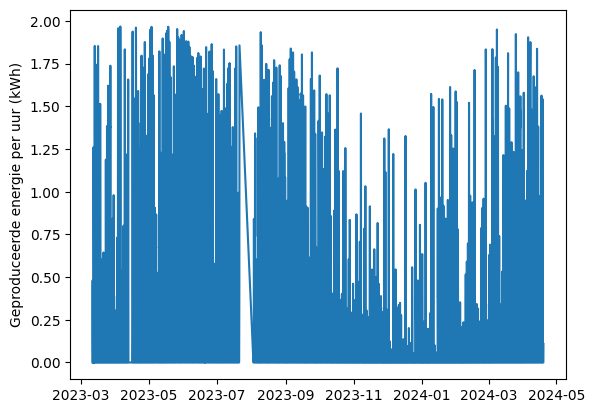

In [102]:
plt.plot(power_filtered['timestamp'], power_filtered['kwh_per_hour'])
plt.ylabel('Geproduceerde energie per uur (kWh)')
plt.show()

In [103]:
power_filtered['date'] = power_filtered['timestamp'].dt.date
daily_output = power_filtered.groupby('date')['kwh_per_hour'].sum().reset_index()
daily_output.columns = ['date', 'daily_kwh']

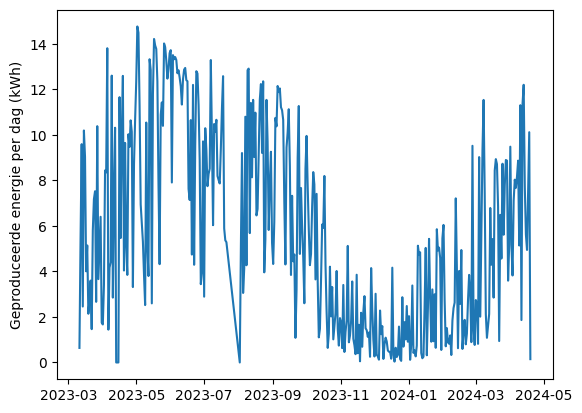

In [104]:
plt.plot(daily_output['date'], daily_output['daily_kwh'])
plt.ylabel('Geproduceerde energie per dag (kWh)')
plt.show()

Hier is duidelijk het effect van de seizoenen zichtbaar in de energieproductie per dag. Rond de zomerzonnewende (21 juni), is er een duidelijke piek in de data. Dit is logisch aangezien dit de dagen zijn met het grootste aantal uren daglicht. Rond de winterzonnewende (21 december), is er dan weer een zichtbaar dal aangezien hier de zon het minste uren per dag schijnt.

#### Onderzoek overgang zomeruur/winteruur

In [105]:
overgang_zomeruur_2023 = power[(power['timestamp'] >= '2023-03-25 23:00:00') & (power['timestamp'] <= '2023-03-26 06:00:00')]
overgang_zomeruur_2023

,timestamp,kwh,kwh_per_hour
344,2023-03-25 23:00:10.610864+00:00,77.5264,0.0
345,2023-03-26 00:00:10.658676+00:00,77.5264,0.0
346,2023-03-26 01:00:10.903616+00:00,77.5264,0.0
347,2023-03-26 02:00:10.762881+00:00,77.5264,0.0
348,2023-03-26 03:00:10.625843+00:00,77.5264,0.0
349,2023-03-26 04:00:10.651412+00:00,77.5264,0.0
350,2023-03-26 05:00:10.903797+00:00,77.5264,0.0


In [106]:
overgang_winteruur_2023 = power[(power['timestamp'] >= '2023-10-28 23:00:00') & (power['timestamp'] <= '2023-10-29 06:00:00')]
overgang_winteruur_2023

,timestamp,kwh,kwh_per_hour
5552,2023-10-28 23:00:10.888879+00:00,1869.3002,0.0
5553,2023-10-29 00:00:10.770127+00:00,1869.3002,0.0


In [107]:
overgang_zomeruur_2024 = power[(power['timestamp'] >= '2023-03-30 23:00:00') & (power['timestamp'] <= '2023-03-31 06:00:00')]
overgang_zomeruur_2024

,timestamp,kwh,kwh_per_hour
464,2023-03-30 23:00:10.742093+00:00,105.6255,0.0
465,2023-03-31 00:00:10.643216+00:00,105.6255,0.0
466,2023-03-31 01:00:10.687063+00:00,105.6255,0.0
467,2023-03-31 02:00:10.685025+00:00,105.6255,0.0
468,2023-03-31 03:00:10.677648+00:00,105.6255,0.0
469,2023-03-31 04:00:10.679560+00:00,105.6255,0.0
470,2023-03-31 05:00:10.973293+00:00,105.6255,0.0


Er zijn geen verschuivingen te zien, dat is logisch omdat de metingen werden gedaan in UTC (Universal Time Coordinated). UTC tijd is gelijk aan wintertijd en houdt geen rekening met zomertijd.

### Weerstation dataset

#### Importeren en visualisatie

In [108]:
weather_big = pd.read_csv('https://raw.githubusercontent.com/HOGENT-ML/course/main/datasets/weather.csv')
weather_big

,FID,the_geom,code,timestamp,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,...,wind_speed_unit,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness
0,synop_data.6418.2023-03-01 09:00:00+00,POINT (51.347375 3.201846),6418,2023-03-01T09:00:00,NaN,NaN,4.9,NaN,NaN,NaN,...,1,50.0,9.4,54.3,NaN,1029.7,1028.0,NaN,NaN,0.0
1,synop_data.6414.2023-03-01 09:00:00+00,POINT (50.90398 3.121692),6414,2023-03-01T09:00:00,NaN,NaN,2.1,NaN,NaN,NaN,...,1,44.7,7.5,73.7,NaN,1029.3,1025.9,NaN,NaN,NaN
2,synop_data.6407.2023-03-01 09:00:00+00,POINT (51.200341 2.887306),6407,2023-03-01T09:00:00,NaN,NaN,3.3,NaN,NaN,NaN,...,1,60.0,7.0,NaN,NaN,1029.6,1029.0,NaN,NaN,1.0
3,synop_data.6434.2023-03-01 09:00:00+00,POINT (50.980293 3.816003),6434,2023-03-01T09:00:00,NaN,NaN,1.6,NaN,NaN,-10.0,...,1,71.6,5.9,70.9,NaN,1029.4,1027.3,NaN,NaN,NaN
4,synop_data.6434.2023-03-01 10:00:00+00,POINT (50.980293 3.816003),6434,2023-03-01T10:00:00,NaN,NaN,3.0,NaN,NaN,NaN,...,1,56.0,7.6,60.8,NaN,1028.8,1026.7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39835,synop_data.6407.2024-04-19 07:00:00+00,POINT (51.200341 2.887306),6407,2024-04-19T07:00:00,NaN,NaN,10.6,NaN,NaN,NaN,...,1,290.0,14.0,NaN,NaN,1013.5,1012.8,NaN,NaN,8.0
39836,synop_data.6434.2024-04-19 08:00:00+00,POINT (50.980293 3.816003),6434,2024-04-19T08:00:00,NaN,NaN,10.0,NaN,NaN,NaN,...,1,276.5,9.8,90.5,NaN,1012.7,1010.7,NaN,NaN,NaN
39837,synop_data.6407.2024-04-19 08:00:00+00,POINT (51.200341 2.887306),6407,2024-04-19T08:00:00,NaN,NaN,10.8,NaN,NaN,NaN,...,1,290.0,15.0,NaN,NaN,1013.2,1012.6,NaN,NaN,8.0
39838,synop_data.6414.2024-04-19 08:00:00+00,POINT (50.90398 3.121692),6414,2024-04-19T08:00:00,NaN,NaN,9.9,NaN,NaN,NaN,...,1,273.3,12.4,89.7,NaN,1013.6,1010.4,NaN,NaN,NaN


In [109]:
weather_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39840 entries, 0 to 39839
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FID                          39840 non-null  object 
 1   the_geom                     39840 non-null  object 
 2   code                         39840 non-null  int64  
 3   timestamp                    39840 non-null  object 
 4   precip_quantity              6291 non-null   float64
 5   precip_range                 6417 non-null   float64
 6   temp                         39840 non-null  float64
 7   temp_min                     1660 non-null   float64
 8   temp_max                     1657 non-null   float64
 9   temp_grass_min               1189 non-null   float64
 10  wind_speed                   39827 non-null  float64
 11  wind_speed_unit              39840 non-null  int64  
 12  wind_direction               39414 non-null  float64
 13  wind_peak_speed 

In [110]:
weather_big['timestamp'] = pd.to_datetime(weather_big['timestamp'], utc=True)

In de forecast.csv staan enkel de volgende 5 kolommen: timestamp, temp, pressure, cloudiness, humidity_relative. We houden dus enkel rekening met die kolommen voor het model en verwijderen de overigen. Verder nemen we de code van het weerstation ook mee.

In [111]:
weather = weather_big[['timestamp', 'code', 'temp', 'pressure', 'cloudiness', 'humidity_relative']]
weather

,timestamp,code,temp,pressure,cloudiness,humidity_relative
0,2023-03-01 09:00:00+00:00,6418,4.9,1029.7,0.0,54.3
1,2023-03-01 09:00:00+00:00,6414,2.1,1029.3,NaN,73.7
2,2023-03-01 09:00:00+00:00,6407,3.3,1029.6,1.0,NaN
3,2023-03-01 09:00:00+00:00,6434,1.6,1029.4,NaN,70.9
4,2023-03-01 10:00:00+00:00,6434,3.0,1028.8,NaN,60.8
...,...,...,...,...,...,...
39835,2024-04-19 07:00:00+00:00,6407,10.6,1013.5,8.0,NaN
39836,2024-04-19 08:00:00+00:00,6434,10.0,1012.7,NaN,90.5
39837,2024-04-19 08:00:00+00:00,6407,10.8,1013.2,8.0,NaN
39838,2024-04-19 08:00:00+00:00,6414,9.9,1013.6,NaN,89.7


In de documentatie staat volgende informatie voor deze metingen:

- TEMP = air temperature at 1.5m in °C (hourly) 1 value every hour: average measured between (T – 11 min) and (T – 10 min)

- PRESSURE = air pressure at sea level (hPa) (hourly) measured between (T – 11 min) and (T – 10 min)

- CLOUDINESS = part of the sky covered in clouds (in octas) instantaneous

- HUMIDITY_RELATIVE = relative humidity of the air in % (hourly) average RH measured/calculated between (T – 11 min) and (T – 10 min)

We zien hier dat cloudiness een classificatie is met 8 mogelijkheden. Het zijn wel waarden die op elkaar volgen dus het is morgelijk om een OrdinalEncoder te gebruiken.

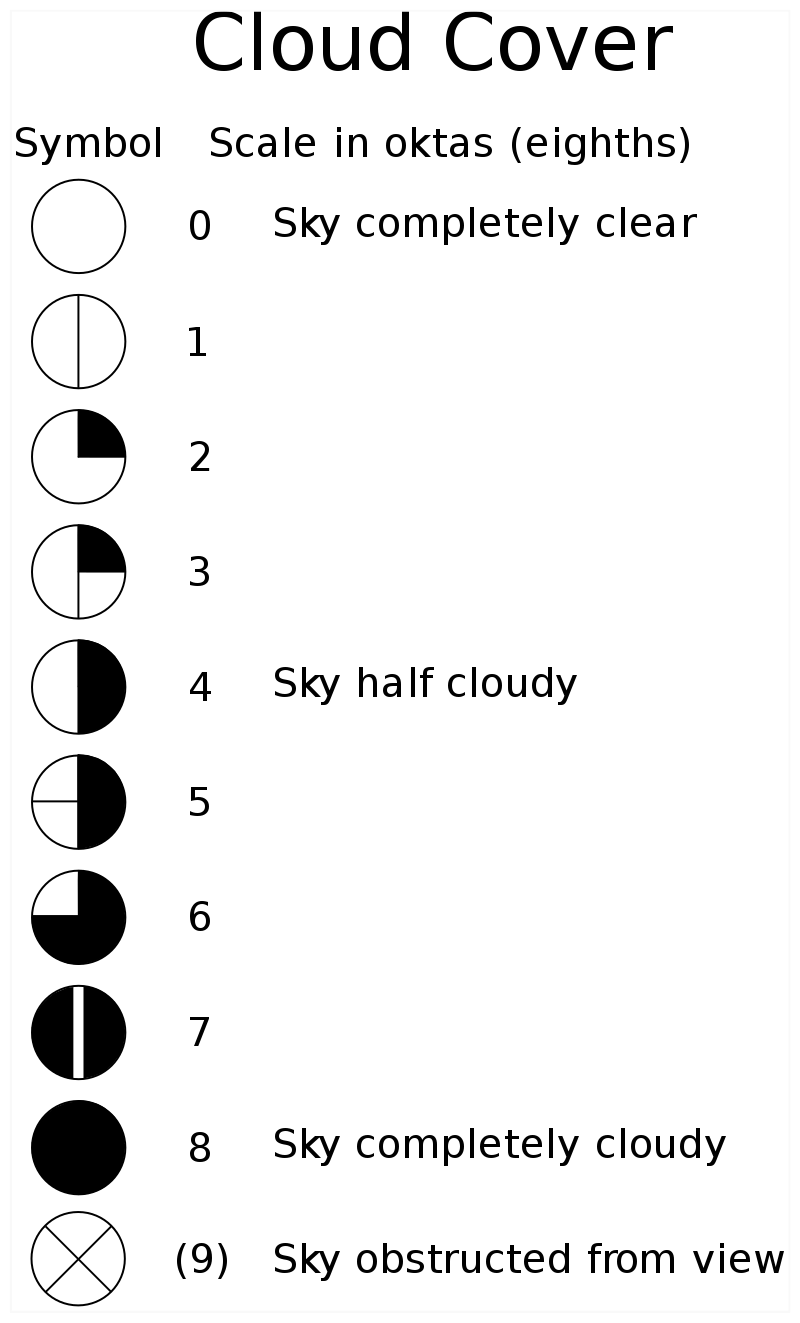

In [112]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39840 entries, 0 to 39839
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          39840 non-null  datetime64[ns, UTC]
 1   code               39840 non-null  int64              
 2   temp               39840 non-null  float64            
 3   pressure           39828 non-null  float64            
 4   cloudiness         15455 non-null  float64            
 5   humidity_relative  29880 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 1.8 MB


Uit het overzicht blijkt dat timestamp en temperatuur altijd ingevuld zijn er enkele ontbrekende waarden zijn bij pressure en dat er bij cloudiness en relative humidity vaak waarden ontbreken.

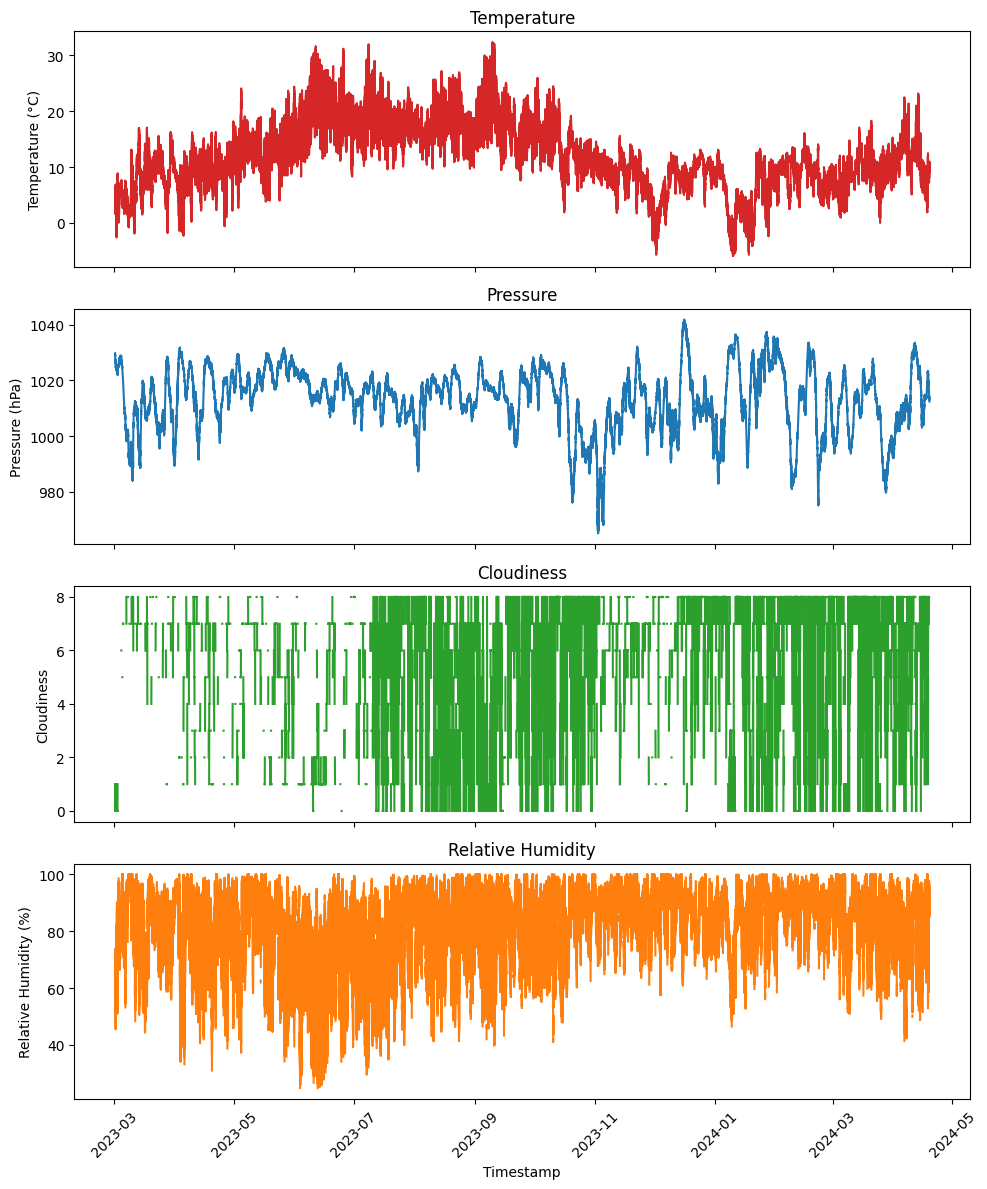

In [113]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot each column on its respective subplot
axs[0].plot(weather['timestamp'], weather['temp'], color='tab:red')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Temperature')

axs[1].plot(weather['timestamp'], weather['pressure'], color='tab:blue')
axs[1].set_ylabel('Pressure (hPa)')
axs[1].set_title('Pressure')

axs[2].plot(weather['timestamp'], weather['cloudiness'], color='tab:green')
axs[2].set_ylabel('Cloudiness')
axs[2].set_title('Cloudiness')

axs[3].plot(weather['timestamp'], weather['humidity_relative'], color='tab:orange')
axs[3].set_ylabel('Relative Humidity (%)')
axs[3].set_title('Relative Humidity')

# Set common labels
plt.xlabel('Timestamp')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


Er zijn enkele logische trends zichtbaar in de data:

- Temperature: In de zomermaanden is het gemiddeld warmer dan in de wintermaanden
- Pressure: In het najaar lijkt de luchtdruk een pak stabieler dan in het voorjaar.
- Cloudiness: Tijdens de herfst en lente lijkt het alsof het meer bewolkt is dan tijdens de zomer en winter. Echter er zijn veel velden niet ingevuld voor Cloudiness. Het zou kunnen zijn dat deze grafiek een vertekend beeld geeft omdat er enkel data ingevuld zijn in bepaalde periodes.
- Relative humidity: De relatieve luchtvochtigheid is behoorlijk constant al is er een duidelijk dip merkbaar rond juni en juli.

#### Data per weerstation

In [114]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39840 entries, 0 to 39839
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          39840 non-null  datetime64[ns, UTC]
 1   code               39840 non-null  int64              
 2   temp               39840 non-null  float64            
 3   pressure           39828 non-null  float64            
 4   cloudiness         15455 non-null  float64            
 5   humidity_relative  29880 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 1.8 MB


In [115]:
weather['code'].value_counts()

code
6418    9960
6414    9960
6407    9960
6434    9960
Name: count, dtype: int64

Elk weerstation heeft evenveel waarnemingen gedaan. 4 x 9960 = 39840

In [116]:
weather_station_1 = weather[weather['code'] == 6407]
weather_station_2 = weather[weather['code'] == 6414]
weather_station_3 = weather[weather['code'] == 6418]
weather_station_4 = weather[weather['code'] == 6434]

In [117]:
weather_station_1.info()
weather_station_2.info()
weather_station_3.info()
weather_station_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9960 entries, 2 to 39837
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          9960 non-null   datetime64[ns, UTC]
 1   code               9960 non-null   int64              
 2   temp               9960 non-null   float64            
 3   pressure           9948 non-null   float64            
 4   cloudiness         9763 non-null   float64            
 5   humidity_relative  0 non-null      float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 544.7 KB
<class 'pandas.core.frame.DataFrame'>
Index: 9960 entries, 1 to 39838
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          9960 non-null   datetime64[ns, UTC]
 1   code               9960 non-null   int64              


De opsplitsing per weerstation onthult dat er een aantal instrumenten niet functioneren bij bepaalde weerstations:
 - Weerstation 1 (6407):
       - Temperatuur: 100% van de metingen
       - Luchtdruk: 99.8% van de metingen
       - Bewolking: 98.0% van de metingen
       - Luchtvochtigheid: 0.0% van de metingen
 - Weerstation 2 (6414):
       - Temperatuur: 100% van de metingen
       - Luchtdruk: 100% van de metingen
       - Bewolking: 0.0% van de metingen
       - Luchtvochtigheid: 100% van de metingen
 - Weerstation 3 (6418):
       - Temperatuur: 100% van de metingen
       - Luchtdruk: 100% van de metingen
       - Bewolking: 57.1% van de metingen
       - Luchtvochtigheid: 100% van de metingen
 - Weerstation 4 (6434):
       - Temperatuur: 100% van de metingen
       - Luchtdruk: 100% van de metingen
       - Bewolking: 0.0% van de metingen
       - Luchtvochtigheid: 100% van de metingen

Zo zien we dat bij weerstations 2 en 4 de bewolkingsmeter helemaal niet werkt en bij weerstation 3 slechts gedeeltelijk. Bij weerstation 1 is de luchtvochtigheidsmeter dan weer kapot.

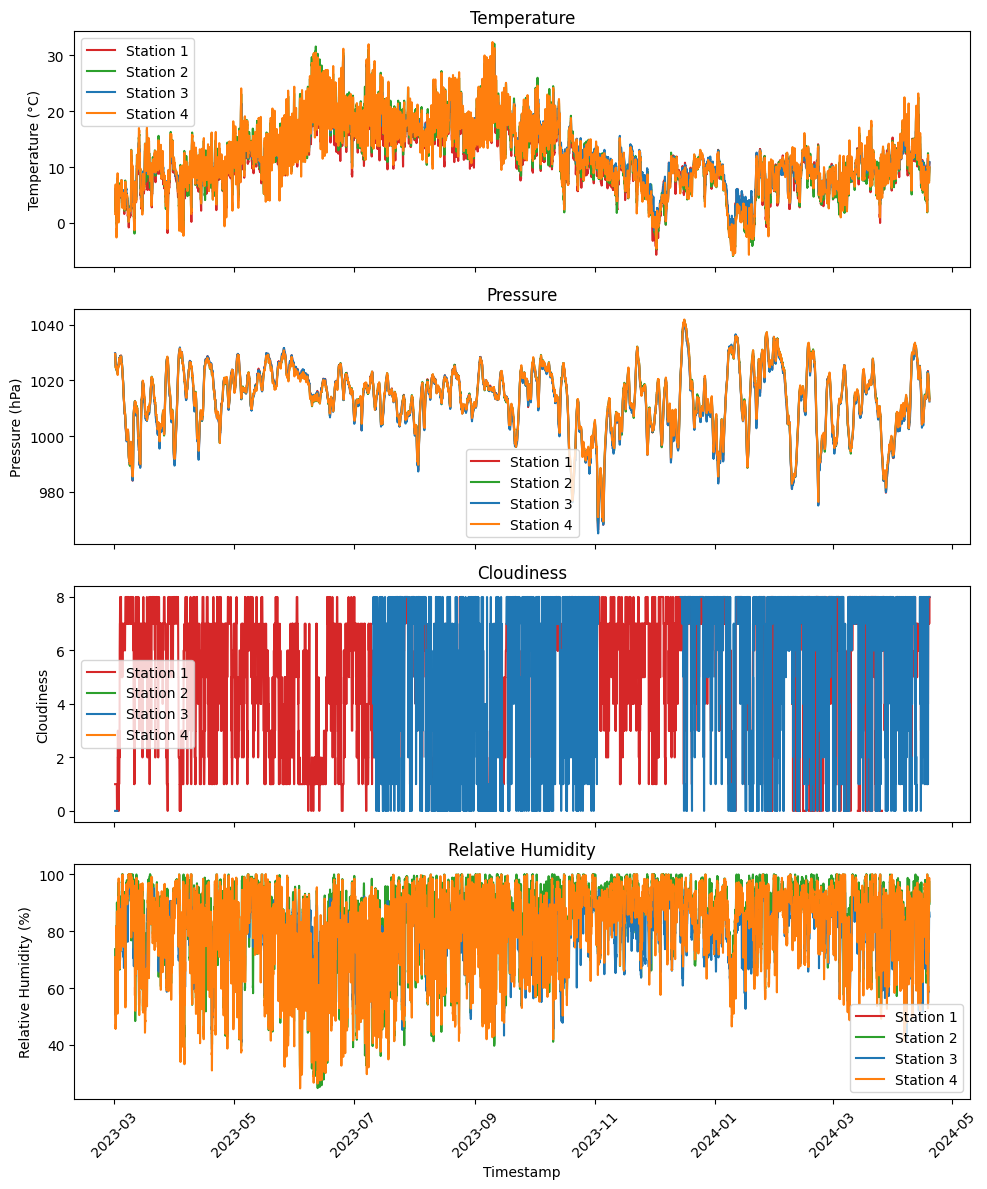

In [118]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

station_labels = ['Station 1', 'Station 2', 'Station 3', 'Station 4']

# Plot each column on its respective subplot
axs[0].plot(weather_station_1['timestamp'], weather_station_1['temp'], color='tab:red', label=station_labels[0])
axs[0].plot(weather_station_2['timestamp'], weather_station_2['temp'], color='tab:green', label=station_labels[1])
axs[0].plot(weather_station_3['timestamp'], weather_station_3['temp'], color='tab:blue', label=station_labels[2])
axs[0].plot(weather_station_4['timestamp'], weather_station_4['temp'], color='tab:orange', label=station_labels[3])
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Temperature')
axs[0].legend()

axs[1].plot(weather_station_1['timestamp'], weather_station_1['pressure'], color='tab:red', label=station_labels[0])
axs[1].plot(weather_station_2['timestamp'], weather_station_2['pressure'], color='tab:green', label=station_labels[1])
axs[1].plot(weather_station_3['timestamp'], weather_station_3['pressure'], color='tab:blue', label=station_labels[2])
axs[1].plot(weather_station_4['timestamp'], weather_station_4['pressure'], color='tab:orange', label=station_labels[3])
axs[1].set_ylabel('Pressure (hPa)')
axs[1].set_title('Pressure')
axs[1].legend()


axs[2].plot(weather_station_1['timestamp'], weather_station_1['cloudiness'], color='tab:red', label=station_labels[0])
axs[2].plot(weather_station_2['timestamp'], weather_station_2['cloudiness'], color='tab:green', label=station_labels[1])
axs[2].plot(weather_station_3['timestamp'], weather_station_3['cloudiness'], color='tab:blue', label=station_labels[2])
axs[2].plot(weather_station_4['timestamp'], weather_station_4['cloudiness'], color='tab:orange', label=station_labels[3])
axs[2].set_ylabel('Cloudiness')
axs[2].set_title('Cloudiness')
axs[2].legend()


axs[3].plot(weather_station_1['timestamp'], weather_station_1['humidity_relative'], color='tab:red', label=station_labels[0])
axs[3].plot(weather_station_2['timestamp'], weather_station_2['humidity_relative'], color='tab:green', label=station_labels[1])
axs[3].plot(weather_station_3['timestamp'], weather_station_3['humidity_relative'], color='tab:blue', label=station_labels[2])
axs[3].plot(weather_station_4['timestamp'], weather_station_4['humidity_relative'], color='tab:orange', label=station_labels[3])
axs[3].set_ylabel('Relative Humidity (%)')
axs[3].set_title('Relative Humidity')
axs[3].legend()


# Set common labels
plt.xlabel('Timestamp')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

Het grootste verschil zien we in de Cloudiness grafiek. Het blijkt dat de waarden van station 3 zich clusteren in specifieke periodes.

#### Onderzoek overgang zomeruur/winteruur

In [119]:
overgang_zomeruur_2023_w1 = weather_station_1[(weather_station_1['timestamp'] >= '2023-03-25 23:00:00') & (weather_station_1['timestamp'] <= '2023-03-26 06:00:00')]
overgang_zomeruur_2023_w1

,timestamp,code,temp,pressure,cloudiness,humidity_relative
2362,2023-03-25 23:00:00+00:00,6407,7.0,1007.9,7.0,NaN
2366,2023-03-26 00:00:00+00:00,6407,7.5,1007.2,7.0,NaN
2370,2023-03-26 01:00:00+00:00,6407,7.7,1006.1,7.0,NaN
2374,2023-03-26 02:00:00+00:00,6407,7.3,1005.1,7.0,NaN
2378,2023-03-26 03:00:00+00:00,6407,7.1,1003.8,7.0,NaN
2381,2023-03-26 04:00:00+00:00,6407,7.0,1002.3,7.0,NaN
2384,2023-03-26 05:00:00+00:00,6407,6.9,1001.4,8.0,NaN
2390,2023-03-26 06:00:00+00:00,6407,7.1,1000.8,8.0,NaN


In [120]:
overgang_winteruur_2023_w1 = weather_station_1[(weather_station_1['timestamp'] >= '2023-10-28 23:00:00') & (weather_station_1['timestamp'] <= '2023-10-29 06:00:00')]
overgang_winteruur_2023_w1

,timestamp,code,temp,pressure,cloudiness,humidity_relative
23195,2023-10-28 23:00:00+00:00,6407,13.4,987.4,7.0,NaN
23196,2023-10-29 00:00:00+00:00,6407,13.3,987.0,6.0,NaN
23203,2023-10-29 01:00:00+00:00,6407,12.4,987.2,7.0,NaN
23204,2023-10-29 02:00:00+00:00,6407,12.6,987.1,7.0,NaN
23210,2023-10-29 03:00:00+00:00,6407,10.9,987.8,8.0,NaN
23212,2023-10-29 04:00:00+00:00,6407,10.8,989.2,7.0,NaN
23219,2023-10-29 05:00:00+00:00,6407,10.8,989.9,6.0,NaN
23220,2023-10-29 06:00:00+00:00,6407,10.6,990.2,7.0,NaN


In [121]:
overgang_zomeruur_2024_w1 = weather_station_1[(weather_station_1['timestamp'] >= '2024-03-30 23:00:00') & (weather_station_1['timestamp'] <= '2024-03-31 06:00:00')]
overgang_zomeruur_2024_w1

,timestamp,code,temp,pressure,cloudiness,humidity_relative
37979,2024-03-30 23:00:00+00:00,6407,7.1,999.6,6.0,NaN
37980,2024-03-31 00:00:00+00:00,6407,6.7,998.7,6.0,NaN
37986,2024-03-31 01:00:00+00:00,6407,6.5,998.2,3.0,NaN
37988,2024-03-31 02:00:00+00:00,6407,5.8,998.2,3.0,NaN
37995,2024-03-31 03:00:00+00:00,6407,6.6,997.4,6.0,NaN
37997,2024-03-31 04:00:00+00:00,6407,6.6,997.1,7.0,NaN
38002,2024-03-31 05:00:00+00:00,6407,7.4,996.4,8.0,NaN
38004,2024-03-31 06:00:00+00:00,6407,7.8,996.2,8.0,NaN


Er zijn geen dubbele data tijdens de overgangen. De dataset gebruikt UTC.

### Zonsondergang dataset

#### Importeren en visualisatie

In [34]:
sunset = pd.read_excel('https://github.com/HOGENT-ML/course/raw/main/datasets/sunrise-sunset.xlsx')
sunset

,datum,Opkomst,Op ware middag,Ondergang
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00
...,...,...,...,...
726,2024-12-27,08:45:00,12:44:00,16:43:00
727,2024-12-28,08:45:00,12:44:00,16:44:00
728,2024-12-29,08:45:00,12:45:00,16:45:00
729,2024-12-30,08:45:00,12:45:00,16:46:00


In [35]:
sunset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datum           731 non-null    datetime64[ns]
 1   Opkomst         731 non-null    object        
 2   Op ware middag  731 non-null    object        
 3   Ondergang       731 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 23.0+ KB


Alle waarden voor alle kolommen zijn gekend. De datum kolom is reeds van het datetime type maar ditmaal is het niet UTC.

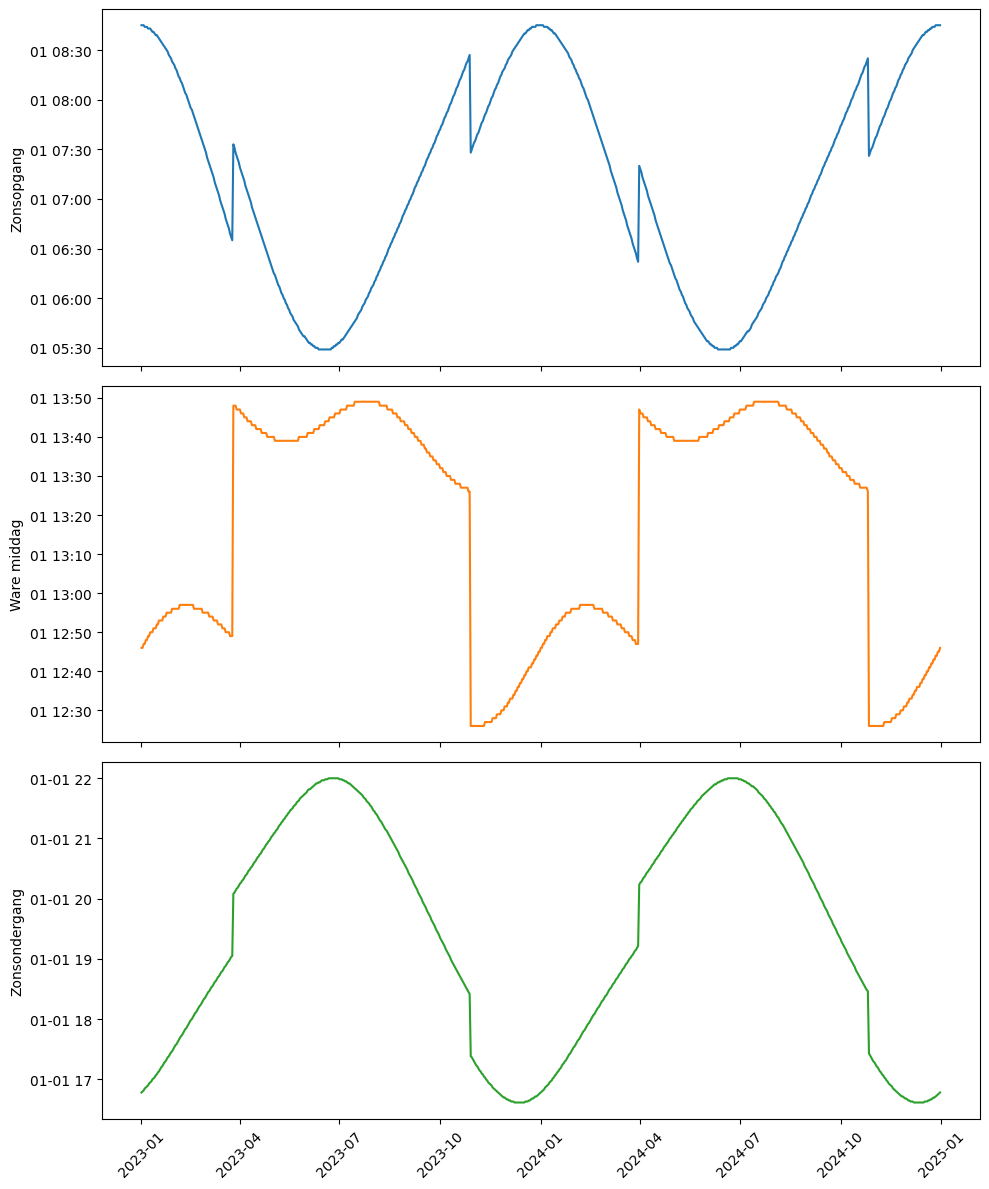

In [36]:
# Convert time columns to datetime objects
sunset['datum'] = pd.to_datetime(sunset['datum'], format='%Y-%m-%d')

sunset['Opkomst'] = pd.to_datetime(sunset['Opkomst'], format='%H:%M:%S')
sunset['Op ware middag'] = pd.to_datetime(sunset['Op ware middag'], format='%H:%M:%S')
sunset['Ondergang'] = pd.to_datetime(sunset['Ondergang'], format='%H:%M:%S')

# Create subplots for each column
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot each column on its respective subplot
axs[0].plot(sunset['datum'], sunset['Opkomst'], color='tab:blue')
axs[0].set_ylabel('Zonsopgang')

axs[1].plot(sunset['datum'], sunset['Op ware middag'], color='tab:orange')
axs[1].set_ylabel('Ware middag')

axs[2].plot(sunset['datum'], sunset['Ondergang'], color='tab:green')
axs[2].set_ylabel('Zonsondergang')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


Er is een periodiciteit zichtbaar in elke kolom. Het is eveneens duidelijk dat deze natuurlijke fenomenen normaal een sinusoidaal verloop hebben, echter wordt dit op vaste momenten verschoven door de overgangen van winter- en zomeruur.

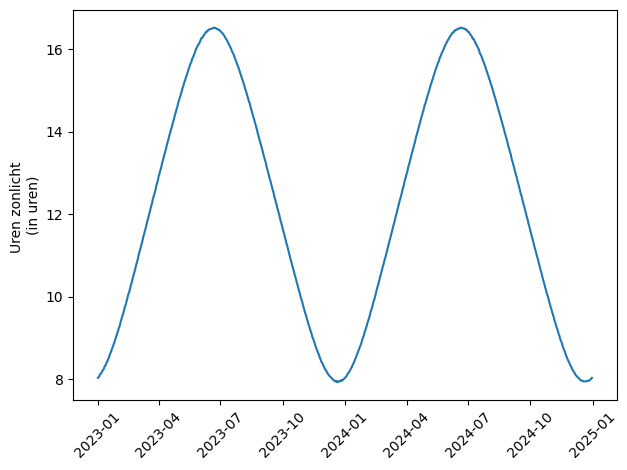

In [37]:
sunset['Uren zonlicht'] = (sunset['Ondergang'] - sunset['Opkomst']).dt.total_seconds() / 3600
plt.plot(sunset['datum'], sunset['Uren zonlicht'])
plt.ylabel('Uren zonlicht \n(in uren)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Door te kijken naar het totaal aan uren daglicht per dag wordt de hypothese bevestigd. Er is geen plotse verschuiving door meetfouten door het toekennen van timestamps die variëren met zomeruur en winteruur.

#### Onderzoek overgang zomeruur

In [38]:
overgangen = pd.to_datetime(['2023-03-25', '2023-03-26', '2023-10-28', '2023-10-29', '2024-03-30', '2024-03-31'])
sunsets = sunset[sunset['datum'].isin(overgangen)]
sunsets

,datum,Opkomst,Op ware middag,Ondergang,Uren zonlicht
83,2023-03-25,1900-01-01 06:35:00,1900-01-01 12:49:00,1900-01-01 19:03:00,12.466667
84,2023-03-26,1900-01-01 07:33:00,1900-01-01 13:48:00,1900-01-01 20:05:00,12.533333
300,2023-10-28,1900-01-01 08:27:00,1900-01-01 13:26:00,1900-01-01 18:25:00,9.966667
301,2023-10-29,1900-01-01 07:28:00,1900-01-01 12:26:00,1900-01-01 17:23:00,9.916667
454,2024-03-30,1900-01-01 06:22:00,1900-01-01 12:47:00,1900-01-01 19:13:00,12.850000
455,2024-03-31,1900-01-01 07:20:00,1900-01-01 13:47:00,1900-01-01 20:14:00,12.900000


We zien 2 dingen:
- Het omvormen van de Opkomst, Op ware middag en Ondergang kolommen van strings naar datetime objecten zonder het specificeren van een datum heeft ervoor gezorgd dat 01/01/1900 gekozen werd.
- Tussen de dagen van de overgang springen de waarden met 1 uur.

In [39]:
sunset['Opkomst'] = sunset['Opkomst'].dt.time
sunset['Ondergang'] = sunset['Ondergang'].dt.time
sunset['Op ware middag'] = sunset['Op ware middag'].dt.time
sunset

,datum,Opkomst,Op ware middag,Ondergang,Uren zonlicht
0,2023-01-01,08:45:00,12:46:00,16:47:00,8.033333
1,2023-01-02,08:45:00,12:46:00,16:48:00,8.050000
2,2023-01-03,08:45:00,12:47:00,16:49:00,8.066667
3,2023-01-04,08:44:00,12:47:00,16:51:00,8.116667
4,2023-01-05,08:44:00,12:48:00,16:52:00,8.133333
...,...,...,...,...,...
726,2024-12-27,08:45:00,12:44:00,16:43:00,7.966667
727,2024-12-28,08:45:00,12:44:00,16:44:00,7.983333
728,2024-12-29,08:45:00,12:45:00,16:45:00,8.000000
729,2024-12-30,08:45:00,12:45:00,16:46:00,8.016667


In [40]:
# if date is > 2023-03-25 and < 2023-10-28 then reduce the time by 1 hour for Opkomst, Op ware middag and Ondergang
sunset['Opkomst_datum'] = sunset['datum'] + pd.to_timedelta(sunset['Opkomst'].astype(str))
sunset['Op ware middag_datum'] = sunset['datum'] + pd.to_timedelta(sunset['Op ware middag'].astype(str))
sunset['Ondergang_datum'] = sunset['datum'] + pd.to_timedelta(sunset['Ondergang'].astype(str))

In [41]:
sunset

,datum,Opkomst,Op ware middag,Ondergang,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum
0,2023-01-01,08:45:00,12:46:00,16:47:00,8.033333,2023-01-01 08:45:00,2023-01-01 12:46:00,2023-01-01 16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00,8.050000,2023-01-02 08:45:00,2023-01-02 12:46:00,2023-01-02 16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00,8.066667,2023-01-03 08:45:00,2023-01-03 12:47:00,2023-01-03 16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00,8.116667,2023-01-04 08:44:00,2023-01-04 12:47:00,2023-01-04 16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00,8.133333,2023-01-05 08:44:00,2023-01-05 12:48:00,2023-01-05 16:52:00
...,...,...,...,...,...,...,...,...
726,2024-12-27,08:45:00,12:44:00,16:43:00,7.966667,2024-12-27 08:45:00,2024-12-27 12:44:00,2024-12-27 16:43:00
727,2024-12-28,08:45:00,12:44:00,16:44:00,7.983333,2024-12-28 08:45:00,2024-12-28 12:44:00,2024-12-28 16:44:00
728,2024-12-29,08:45:00,12:45:00,16:45:00,8.000000,2024-12-29 08:45:00,2024-12-29 12:45:00,2024-12-29 16:45:00
729,2024-12-30,08:45:00,12:45:00,16:46:00,8.016667,2024-12-30 08:45:00,2024-12-30 12:45:00,2024-12-30 16:46:00


Zomeruur 2023 terugdraaien:

In [42]:
sunset['Opkomst_datum'] = np.where((sunset['datum'] > '2023-03-25') & (sunset['datum'] < '2023-10-29'), sunset['Opkomst_datum'] - pd.Timedelta(hours=1), sunset['Opkomst_datum'])
sunset['Op ware middag_datum'] = np.where((sunset['datum'] > '2023-03-25') & (sunset['datum'] < '2023-10-29'), sunset['Op ware middag_datum'] - pd.Timedelta(hours=1), sunset['Op ware middag_datum'])
sunset['Ondergang_datum'] = np.where((sunset['datum'] > '2023-03-25') & (sunset['datum'] < '2023-10-29'), sunset['Ondergang_datum'] - pd.Timedelta(hours=1), sunset['Ondergang_datum'])

Zomeruur 2024 terugdraaien

In [43]:
sunset['Opkomst_datum'] = np.where((sunset['datum'] > '2024-03-30') & (sunset['datum'] < '2024-10-27'), sunset['Opkomst_datum'] - pd.Timedelta(hours=1), sunset['Opkomst_datum'])
sunset['Op ware middag_datum'] = np.where((sunset['datum'] > '2024-03-30') & (sunset['datum'] < '2024-10-27'), sunset['Op ware middag_datum'] - pd.Timedelta(hours=1), sunset['Op ware middag_datum'])
sunset['Ondergang_datum'] = np.where((sunset['datum'] > '2024-03-30') & (sunset['datum'] < '2024-10-27'), sunset['Ondergang_datum'] - pd.Timedelta(hours=1), sunset['Ondergang_datum'])

In [44]:
sunset['Opkomst'] = sunset['Opkomst_datum'].dt.time
sunset['Ondergang'] = sunset['Ondergang_datum'].dt.time
sunset['Op ware middag'] = sunset['Op ware middag_datum'].dt.time
sunset

,datum,Opkomst,Op ware middag,Ondergang,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum
0,2023-01-01,08:45:00,12:46:00,16:47:00,8.033333,2023-01-01 08:45:00,2023-01-01 12:46:00,2023-01-01 16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00,8.050000,2023-01-02 08:45:00,2023-01-02 12:46:00,2023-01-02 16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00,8.066667,2023-01-03 08:45:00,2023-01-03 12:47:00,2023-01-03 16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00,8.116667,2023-01-04 08:44:00,2023-01-04 12:47:00,2023-01-04 16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00,8.133333,2023-01-05 08:44:00,2023-01-05 12:48:00,2023-01-05 16:52:00
...,...,...,...,...,...,...,...,...
726,2024-12-27,08:45:00,12:44:00,16:43:00,7.966667,2024-12-27 08:45:00,2024-12-27 12:44:00,2024-12-27 16:43:00
727,2024-12-28,08:45:00,12:44:00,16:44:00,7.983333,2024-12-28 08:45:00,2024-12-28 12:44:00,2024-12-28 16:44:00
728,2024-12-29,08:45:00,12:45:00,16:45:00,8.000000,2024-12-29 08:45:00,2024-12-29 12:45:00,2024-12-29 16:45:00
729,2024-12-30,08:45:00,12:45:00,16:46:00,8.016667,2024-12-30 08:45:00,2024-12-30 12:45:00,2024-12-30 16:46:00


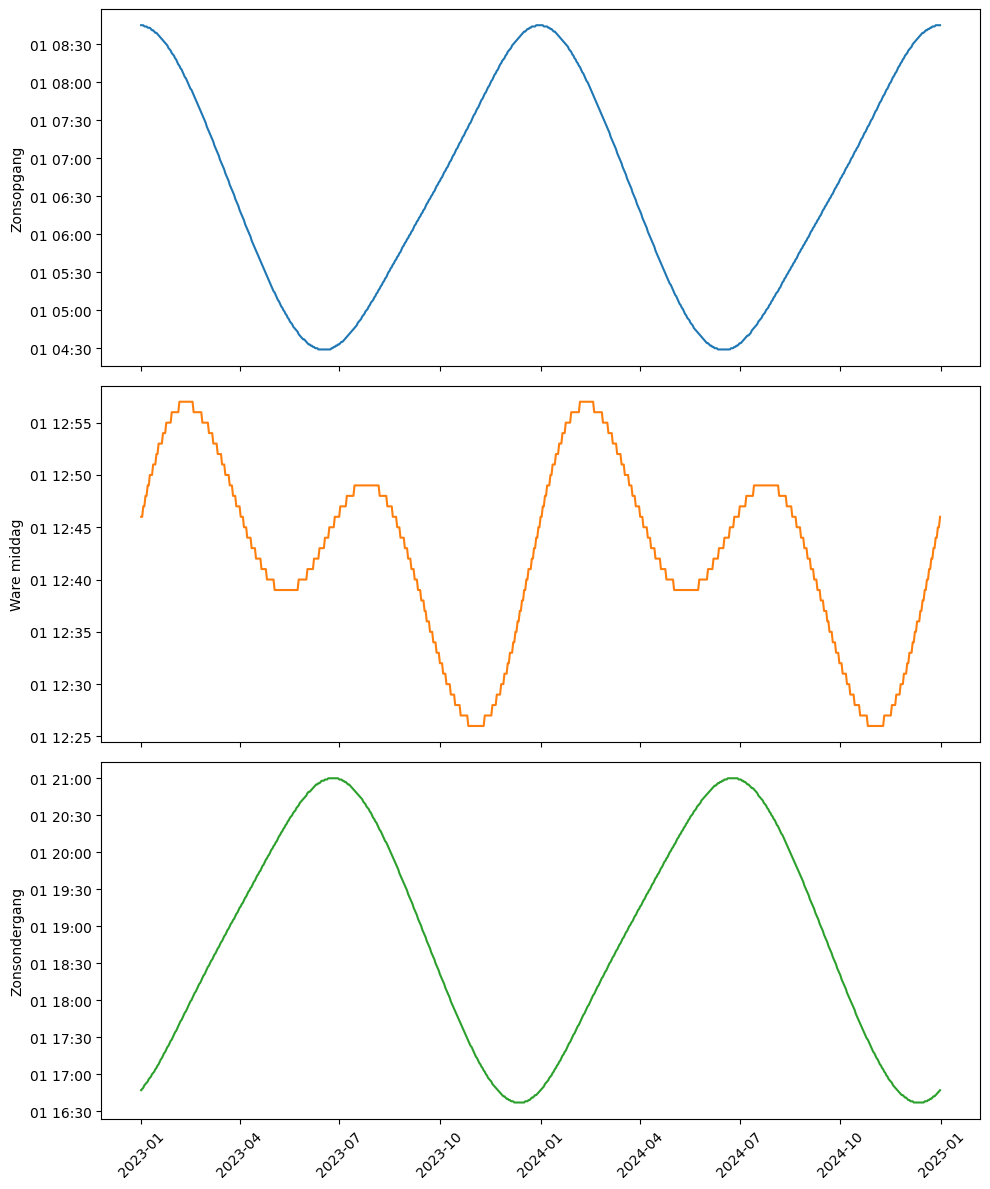

In [45]:
# Create subplots for each column
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

sunset['Opkomst'] = pd.to_datetime(sunset['Opkomst'], format='%H:%M:%S')
sunset['Op ware middag'] = pd.to_datetime(sunset['Op ware middag'], format='%H:%M:%S')
sunset['Ondergang'] = pd.to_datetime(sunset['Ondergang'], format='%H:%M:%S')

# Plot each column on its respective subplot
axs[0].plot(sunset['datum'], sunset['Opkomst'], color='tab:blue')
axs[0].set_ylabel('Zonsopgang')

axs[1].plot(sunset['datum'], sunset['Op ware middag'], color='tab:orange')
axs[1].set_ylabel('Ware middag')

axs[2].plot(sunset['datum'], sunset['Ondergang'], color='tab:green')
axs[2].set_ylabel('Zonsondergang')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

Het zomeruur werd uit de data gehaald.

## Samenvoeging datasets

### Voorbereiden Weerstation data

#### Gemiddelde van 4 weerstations

In [122]:
weather.head(10)

,timestamp,code,temp,pressure,cloudiness,humidity_relative
0,2023-03-01 09:00:00+00:00,6418,4.9,1029.7,0.0,54.3
1,2023-03-01 09:00:00+00:00,6414,2.1,1029.3,NaN,73.7
2,2023-03-01 09:00:00+00:00,6407,3.3,1029.6,1.0,NaN
3,2023-03-01 09:00:00+00:00,6434,1.6,1029.4,NaN,70.9
4,2023-03-01 10:00:00+00:00,6434,3.0,1028.8,NaN,60.8
5,2023-03-01 10:00:00+00:00,6418,5.3,1029.6,0.0,55.6
6,2023-03-01 10:00:00+00:00,6414,3.5,1028.9,NaN,66.3
7,2023-03-01 10:00:00+00:00,6407,4.2,1029.3,1.0,NaN
8,2023-03-01 11:00:00+00:00,6414,4.4,1028.2,NaN,59.9
9,2023-03-01 11:00:00+00:00,6418,5.7,1029.1,0.0,52.1


We nemen het gemiddelde van de 4 weerstations als input voor het model.

In [123]:
weather_mean = weather.groupby('timestamp').mean()
weather_mean.reset_index(inplace=True)
weather_mean.drop(columns='code', inplace=True)
weather_mean

,timestamp,temp,pressure,cloudiness,humidity_relative
0,2023-03-01 09:00:00+00:00,2.975,1029.500,0.5,66.300000
1,2023-03-01 10:00:00+00:00,4.000,1029.150,0.5,60.900000
2,2023-03-01 11:00:00+00:00,4.800,1028.575,0.5,55.000000
3,2023-03-01 12:00:00+00:00,5.375,1028.100,0.5,53.166667
4,2023-03-01 13:00:00+00:00,5.900,1027.125,0.5,51.833333
...,...,...,...,...,...
9955,2024-04-19 04:00:00+00:00,8.750,1014.100,7.5,93.900000
9956,2024-04-19 05:00:00+00:00,9.300,1013.675,7.5,93.600000
9957,2024-04-19 06:00:00+00:00,9.575,1013.475,8.0,91.666667
9958,2024-04-19 07:00:00+00:00,9.925,1013.325,8.0,91.066667


In [48]:
# weather_mean['cloudiness'] = weather_mean['cloudiness'].round()
# weather_mean.head(100)


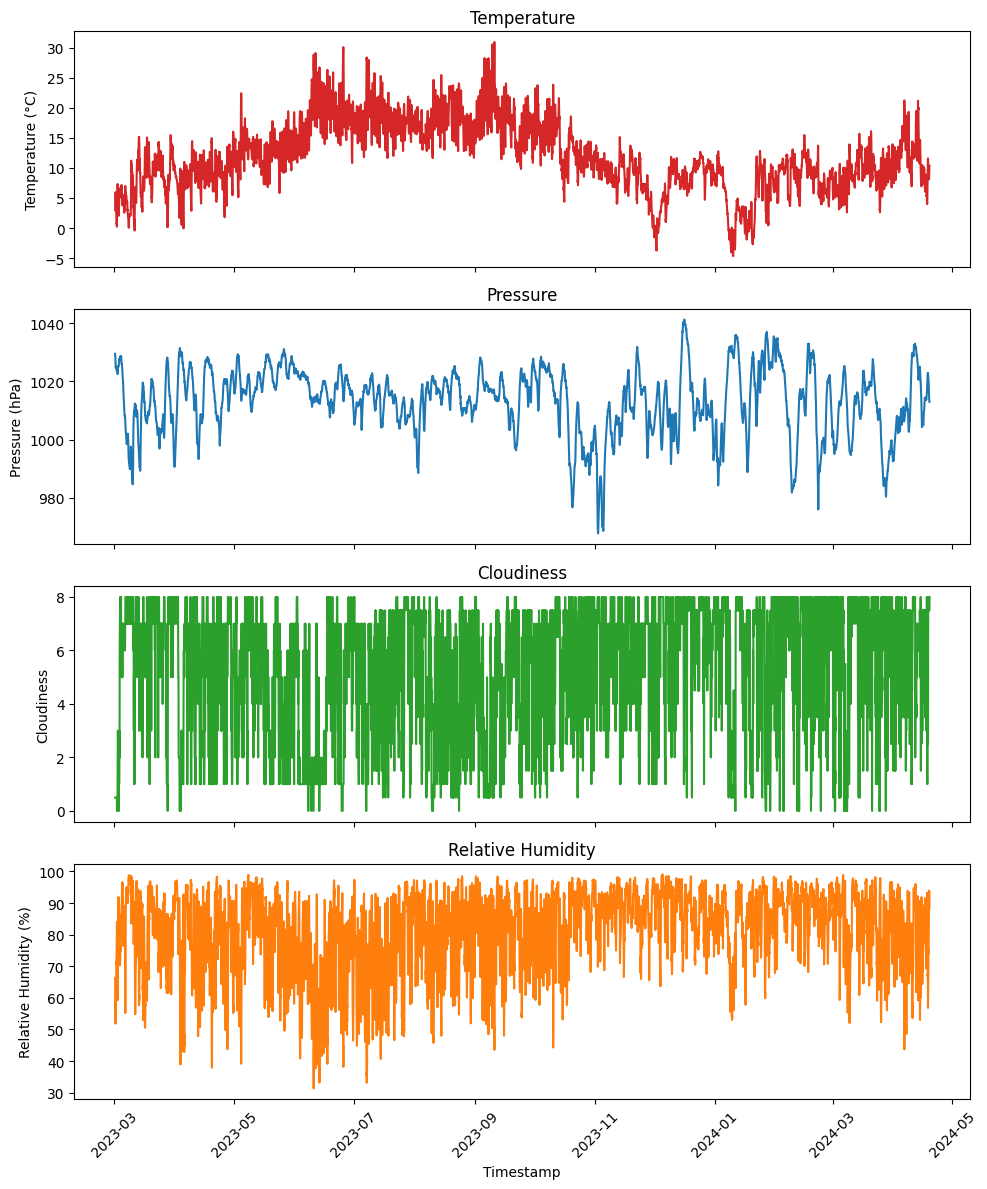

In [124]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot each column on its respective subplot
axs[0].plot(weather_mean['timestamp'], weather_mean['temp'], color='tab:red')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Temperature')

axs[1].plot(weather_mean['timestamp'], weather_mean['pressure'], color='tab:blue')
axs[1].set_ylabel('Pressure (hPa)')
axs[1].set_title('Pressure')

axs[2].plot(weather_mean['timestamp'], weather_mean['cloudiness'], color='tab:green')
axs[2].set_ylabel('Cloudiness')
axs[2].set_title('Cloudiness')

axs[3].plot(weather_mean['timestamp'], weather_mean['humidity_relative'], color='tab:orange')
axs[3].set_ylabel('Relative Humidity (%)')
axs[3].set_title('Relative Humidity')

# Set common labels
plt.xlabel('Timestamp')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [125]:
weather_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9960 entries, 0 to 9959
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          9960 non-null   datetime64[ns, UTC]
 1   temp               9960 non-null   float64            
 2   pressure           9960 non-null   float64            
 3   cloudiness         9960 non-null   float64            
 4   humidity_relative  9960 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 389.2 KB


Elke kolom heeft nu allemaal niet null waarden.

#### Data per weerstation apart

In [126]:
# Pivot the dataframe
weather_pivot = weather.pivot_table(index='timestamp', columns='code', 
                                    values=['temp', 'pressure', 'cloudiness', 'humidity_relative'])

# Flatten the MultiIndex columns
weather_pivot.columns = [f'{var}_{code}' for var, code in weather_pivot.columns]

# Reset the index to make 'timestamp' a column again
weather_pivot.reset_index(inplace=True)

# Display the reshaped dataframe
print(weather_pivot)

                     timestamp  cloudiness_6407  cloudiness_6418  \
0    2023-03-01 09:00:00+00:00              1.0              0.0   
1    2023-03-01 10:00:00+00:00              1.0              0.0   
2    2023-03-01 11:00:00+00:00              1.0              0.0   
3    2023-03-01 12:00:00+00:00              1.0              0.0   
4    2023-03-01 13:00:00+00:00              1.0              0.0   
...                        ...              ...              ...   
9955 2024-04-19 04:00:00+00:00              7.0              8.0   
9956 2024-04-19 05:00:00+00:00              7.0              8.0   
9957 2024-04-19 06:00:00+00:00              8.0              8.0   
9958 2024-04-19 07:00:00+00:00              8.0              8.0   
9959 2024-04-19 08:00:00+00:00              8.0              8.0   

      humidity_relative_6414  humidity_relative_6418  humidity_relative_6434  \
0                       73.7                    54.3                    70.9   
1                      

In [127]:
weather_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9960 entries, 0 to 9959
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   timestamp               9960 non-null   datetime64[ns, UTC]
 1   cloudiness_6407         9763 non-null   float64            
 2   cloudiness_6418         5692 non-null   float64            
 3   humidity_relative_6414  9960 non-null   float64            
 4   humidity_relative_6418  9960 non-null   float64            
 5   humidity_relative_6434  9960 non-null   float64            
 6   pressure_6407           9948 non-null   float64            
 7   pressure_6414           9960 non-null   float64            
 8   pressure_6418           9960 non-null   float64            
 9   pressure_6434           9960 non-null   float64            
 10  temp_6407               9960 non-null   float64            
 11  temp_6414               9960 non-null   flo

In [128]:
weather_pivot[['temp_6407', 'pressure_6407', 'cloudiness_6407']].head()

,temp_6407,pressure_6407,cloudiness_6407
0,3.3,1029.6,1.0
1,4.2,1029.3,1.0
2,4.9,1028.7,1.0
3,4.9,1028.3,1.0
4,5.4,1027.3,1.0


In [129]:
weather[weather['code'] == 6407][['temp', 'pressure', 'cloudiness']].head()


,temp,pressure,cloudiness
2,3.3,1029.6,1.0
7,4.2,1029.3,1.0
10,4.9,1028.7,1.0
15,4.9,1028.3,1.0
16,5.4,1027.3,1.0


### Voorbereiden Zonnepaneel data

In [130]:
power_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9690 entries, 0 to 9704
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   timestamp     9690 non-null   datetime64[ns, UTC]
 1   kwh           9690 non-null   float64            
 2   kwh_per_hour  9690 non-null   float64            
 3   date          9690 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(2), object(1)
memory usage: 378.5+ KB


In [131]:
power_filtered.head()

,timestamp,kwh,kwh_per_hour,date
0,2023-03-11 15:00:10.160454+00:00,0.54,0.00,2023-03-11
1,2023-03-11 16:00:10.217795+00:00,1.02,0.48,2023-03-11
2,2023-03-11 17:00:10.284064+00:00,1.17,0.15,2023-03-11
3,2023-03-11 18:00:10.224836+00:00,1.18,0.01,2023-03-11
4,2023-03-11 19:00:10.201847+00:00,1.18,0.00,2023-03-11


In [132]:
power_filtered.drop(columns=['kwh'], inplace=True)
power_filtered.drop(columns=['date'], inplace=True)

In [133]:
power_filtered.head()

,timestamp,kwh_per_hour
0,2023-03-11 15:00:10.160454+00:00,0.00
1,2023-03-11 16:00:10.217795+00:00,0.48
2,2023-03-11 17:00:10.284064+00:00,0.15
3,2023-03-11 18:00:10.224836+00:00,0.01
4,2023-03-11 19:00:10.201847+00:00,0.00


In [134]:
# round timestamp to the nearest hour
power_filtered['timestamp'] = power_filtered['timestamp'].dt.round('H')
power_filtered.head()

C:\Users\robin\AppData\Local\Temp\ipykernel_16476\720275271.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  power_filtered['timestamp'] = power_filtered['timestamp'].dt.round('H')


,timestamp,kwh_per_hour
0,2023-03-11 15:00:00+00:00,0.00
1,2023-03-11 16:00:00+00:00,0.48
2,2023-03-11 17:00:00+00:00,0.15
3,2023-03-11 18:00:00+00:00,0.01
4,2023-03-11 19:00:00+00:00,0.00


### Samenvoeging

#### Gemiddelde van 4 weerstations

In [135]:
power_weather = pd.merge(power_filtered, weather_mean, on='timestamp', how='inner')

In [136]:
power_weather.head()

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative
0,2023-03-11 15:00:00+00:00,0.00,6.85,1012.025,6.0,54.833333
1,2023-03-11 16:00:00+00:00,0.48,6.30,1011.625,7.0,57.800000
2,2023-03-11 17:00:00+00:00,0.15,5.95,1011.500,7.0,60.366667
3,2023-03-11 18:00:00+00:00,0.01,5.25,1011.850,7.0,64.500000
4,2023-03-11 19:00:00+00:00,0.00,4.85,1011.650,7.0,68.633333


#### Data van 4 weerstations apart

In [137]:
power_weather = pd.merge(power_weather, weather_pivot, on='timestamp', how='inner')

In [138]:
power_weather.head()

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,cloudiness_6407,cloudiness_6418,humidity_relative_6414,humidity_relative_6418,humidity_relative_6434,pressure_6407,pressure_6414,pressure_6418,pressure_6434,temp_6407,temp_6414,temp_6418,temp_6434
0,2023-03-11 15:00:00+00:00,0.00,6.85,1012.025,6.0,54.833333,6.0,NaN,48.4,64.1,52.0,1012.0,1011.9,1012.0,1012.2,6.3,7.3,6.4,7.4
1,2023-03-11 16:00:00+00:00,0.48,6.30,1011.625,7.0,57.800000,7.0,NaN,53.0,66.0,54.4,1011.5,1011.5,1011.6,1011.9,5.8,7.0,5.6,6.8
2,2023-03-11 17:00:00+00:00,0.15,5.95,1011.500,7.0,60.366667,7.0,NaN,55.0,65.4,60.7,1011.4,1011.3,1011.6,1011.7,5.5,6.7,5.5,6.1
3,2023-03-11 18:00:00+00:00,0.01,5.25,1011.850,7.0,64.500000,7.0,NaN,63.9,65.7,63.9,1011.6,1011.8,1011.9,1012.1,4.5,6.1,5.4,5.0
4,2023-03-11 19:00:00+00:00,0.00,4.85,1011.650,7.0,68.633333,7.0,NaN,64.9,67.8,73.2,1011.3,1011.5,1011.6,1012.2,4.6,5.9,5.2,3.7


## Correlatie onderzoek

### Huidige data

In [144]:
power_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9690 entries, 0 to 9689
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   timestamp               9690 non-null   datetime64[ns, UTC]
 1   kwh_per_hour            9690 non-null   float64            
 2   temp                    9690 non-null   float64            
 3   pressure                9690 non-null   float64            
 4   cloudiness              9690 non-null   float64            
 5   humidity_relative       9690 non-null   float64            
 6   cloudiness_6407         9493 non-null   float64            
 7   cloudiness_6418         5657 non-null   float64            
 8   humidity_relative_6414  9690 non-null   float64            
 9   humidity_relative_6418  9690 non-null   float64            
 10  humidity_relative_6434  9690 non-null   float64            
 11  pressure_6407           9678 non-null   flo

In [139]:
corr_matrix = power_weather.corr()

In [140]:
corr_matrix['kwh_per_hour'].sort_values(ascending=False)

kwh_per_hour              1.000000
temp_6414                 0.437688
temp_6434                 0.435378
temp                      0.395340
temp_6407                 0.386789
temp_6418                 0.284353
pressure_6407             0.178615
pressure_6418             0.177861
pressure                  0.168793
pressure_6414             0.160266
pressure_6434             0.159144
timestamp                -0.161242
cloudiness_6407          -0.225977
cloudiness               -0.271898
cloudiness_6418          -0.320270
humidity_relative_6418   -0.411679
humidity_relative        -0.635228
humidity_relative_6434   -0.644523
humidity_relative_6414   -0.676693
Name: kwh_per_hour, dtype: float64

Over het algemeen is het duidelijk dat de output van de zonnepanelen erg gecorreleerd is aan de weerdata.

 - Temperatuur en luchtdruk zijn positief gerelateerd. Dit is logisch aangezien hogere temperaturen vaak samengaan met meer zon en een hogere luchtdruk betekent minder wolken en dus minder obstructie voor het zonlicht.

 - Bewolking en relatieve luchtvochtigheid zijn dan weer negatief gecorreleerd. Voor bewolking is dit eveneens eenvoudig te verklaren, meer wolken betekent dan ook minder zonlicht. Relatieve luchtvochtigheid is een maatstaaf voor het opgenomen water in de lucht. Een hogere waarde hier betekent dan hoogst waarschijnlijk een aanwezigheid van neerslag en neerslag gaat opnieuw gepaard met bewolking.

 - Het is ook duidelijk dat temperatuur en relatieve luchtvochtigheid sterker gecorreleerd zijn met de energie productie dan luchtdruk en bewolking.

 - Verder is te zien hoe weerstation 6418 significant slechter scoort dan de overige weestations voor in juist temperatuur en relatieve luchtvochtigheid. Voor bewolking scoort station 6418 dan wel goed, maar we weten dat slechts 58% van de data ingevuld was. Het kan mogelijks kan deze data achterwege gelaten worden bij het trainen van het model.


array([[<Axes: xlabel='kwh_per_hour', ylabel='kwh_per_hour'>,
        <Axes: xlabel='temp_6407', ylabel='kwh_per_hour'>,
        <Axes: xlabel='temp_6414', ylabel='kwh_per_hour'>,
        <Axes: xlabel='temp_6418', ylabel='kwh_per_hour'>,
        <Axes: xlabel='temp_6434', ylabel='kwh_per_hour'>],
       [<Axes: xlabel='kwh_per_hour', ylabel='temp_6407'>,
        <Axes: xlabel='temp_6407', ylabel='temp_6407'>,
        <Axes: xlabel='temp_6414', ylabel='temp_6407'>,
        <Axes: xlabel='temp_6418', ylabel='temp_6407'>,
        <Axes: xlabel='temp_6434', ylabel='temp_6407'>],
       [<Axes: xlabel='kwh_per_hour', ylabel='temp_6414'>,
        <Axes: xlabel='temp_6407', ylabel='temp_6414'>,
        <Axes: xlabel='temp_6414', ylabel='temp_6414'>,
        <Axes: xlabel='temp_6418', ylabel='temp_6414'>,
        <Axes: xlabel='temp_6434', ylabel='temp_6414'>],
       [<Axes: xlabel='kwh_per_hour', ylabel='temp_6418'>,
        <Axes: xlabel='temp_6407', ylabel='temp_6418'>,
        <Axes: xla

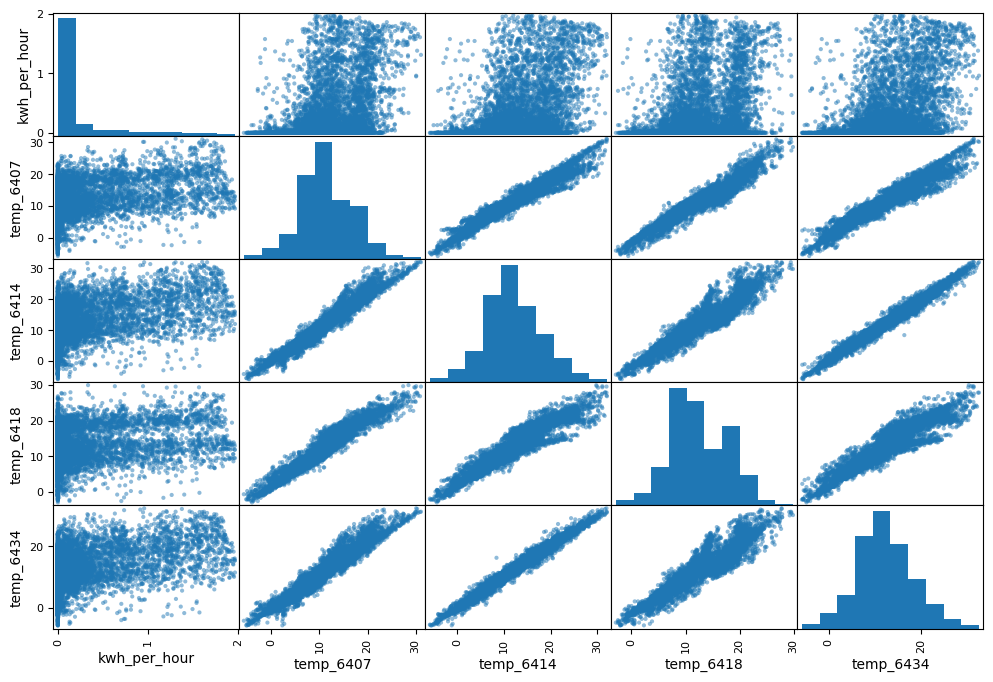

In [142]:
from pandas.plotting import scatter_matrix

attributes = ["kwh_per_hour", "temp_6407", "temp_6414",
              "temp_6418", "temp_6434"]
scatter_matrix(power_weather[attributes], figsize=(12, 8))

### Experimenteren met berekende data

#### Invoegen zonondergang data

In [145]:
power_weather.head()

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,cloudiness_6407,cloudiness_6418,humidity_relative_6414,humidity_relative_6418,humidity_relative_6434,pressure_6407,pressure_6414,pressure_6418,pressure_6434,temp_6407,temp_6414,temp_6418,temp_6434
0,2023-03-11 15:00:00+00:00,0.00,6.85,1012.025,6.0,54.833333,6.0,NaN,48.4,64.1,52.0,1012.0,1011.9,1012.0,1012.2,6.3,7.3,6.4,7.4
1,2023-03-11 16:00:00+00:00,0.48,6.30,1011.625,7.0,57.800000,7.0,NaN,53.0,66.0,54.4,1011.5,1011.5,1011.6,1011.9,5.8,7.0,5.6,6.8
2,2023-03-11 17:00:00+00:00,0.15,5.95,1011.500,7.0,60.366667,7.0,NaN,55.0,65.4,60.7,1011.4,1011.3,1011.6,1011.7,5.5,6.7,5.5,6.1
3,2023-03-11 18:00:00+00:00,0.01,5.25,1011.850,7.0,64.500000,7.0,NaN,63.9,65.7,63.9,1011.6,1011.8,1011.9,1012.1,4.5,6.1,5.4,5.0
4,2023-03-11 19:00:00+00:00,0.00,4.85,1011.650,7.0,68.633333,7.0,NaN,64.9,67.8,73.2,1011.3,1011.5,1011.6,1012.2,4.6,5.9,5.2,3.7


In [147]:
sunset.head()

,datum,Opkomst,Op ware middag,Ondergang,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum
0,2023-01-01,1900-01-01 08:45:00,1900-01-01 12:46:00,1900-01-01 16:47:00,8.033333,2023-01-01 08:45:00,2023-01-01 12:46:00,2023-01-01 16:47:00
1,2023-01-02,1900-01-01 08:45:00,1900-01-01 12:46:00,1900-01-01 16:48:00,8.050000,2023-01-02 08:45:00,2023-01-02 12:46:00,2023-01-02 16:48:00
2,2023-01-03,1900-01-01 08:45:00,1900-01-01 12:47:00,1900-01-01 16:49:00,8.066667,2023-01-03 08:45:00,2023-01-03 12:47:00,2023-01-03 16:49:00
3,2023-01-04,1900-01-01 08:44:00,1900-01-01 12:47:00,1900-01-01 16:51:00,8.116667,2023-01-04 08:44:00,2023-01-04 12:47:00,2023-01-04 16:51:00
4,2023-01-05,1900-01-01 08:44:00,1900-01-01 12:48:00,1900-01-01 16:52:00,8.133333,2023-01-05 08:44:00,2023-01-05 12:48:00,2023-01-05 16:52:00


In [148]:
sunset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datum                 731 non-null    datetime64[ns]
 1   Opkomst               731 non-null    datetime64[ns]
 2   Op ware middag        731 non-null    datetime64[ns]
 3   Ondergang             731 non-null    datetime64[ns]
 4   Uren zonlicht         731 non-null    float64       
 5   Opkomst_datum         731 non-null    datetime64[ns]
 6   Op ware middag_datum  731 non-null    datetime64[ns]
 7   Ondergang_datum       731 non-null    datetime64[ns]
dtypes: datetime64[ns](7), float64(1)
memory usage: 45.8 KB


In [151]:
power_weather['date'] = power_weather['timestamp'].dt.date
power_weather['date'] = pd.to_datetime(power_weather['date'])

In [152]:
power_weather_sunset = pd.merge(power_weather, sunset, left_on='date', right_on='datum', how='left')

In [153]:
power_weather_sunset.head()

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,cloudiness_6407,cloudiness_6418,humidity_relative_6414,humidity_relative_6418,...,temp_6434,date,datum,Opkomst,Op ware middag,Ondergang,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum
0,2023-03-11 15:00:00+00:00,0.00,6.85,1012.025,6.0,54.833333,6.0,NaN,48.4,64.1,...,7.4,2023-03-11,2023-03-11,1900-01-01 07:06:00,1900-01-01 12:53:00,1900-01-01 18:40:00,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
1,2023-03-11 16:00:00+00:00,0.48,6.30,1011.625,7.0,57.800000,7.0,NaN,53.0,66.0,...,6.8,2023-03-11,2023-03-11,1900-01-01 07:06:00,1900-01-01 12:53:00,1900-01-01 18:40:00,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
2,2023-03-11 17:00:00+00:00,0.15,5.95,1011.500,7.0,60.366667,7.0,NaN,55.0,65.4,...,6.1,2023-03-11,2023-03-11,1900-01-01 07:06:00,1900-01-01 12:53:00,1900-01-01 18:40:00,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
3,2023-03-11 18:00:00+00:00,0.01,5.25,1011.850,7.0,64.500000,7.0,NaN,63.9,65.7,...,5.0,2023-03-11,2023-03-11,1900-01-01 07:06:00,1900-01-01 12:53:00,1900-01-01 18:40:00,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
4,2023-03-11 19:00:00+00:00,0.00,4.85,1011.650,7.0,68.633333,7.0,NaN,64.9,67.8,...,3.7,2023-03-11,2023-03-11,1900-01-01 07:06:00,1900-01-01 12:53:00,1900-01-01 18:40:00,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00


In [154]:
power_weather_sunset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9690 entries, 0 to 9689
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   timestamp               9690 non-null   datetime64[ns, UTC]
 1   kwh_per_hour            9690 non-null   float64            
 2   temp                    9690 non-null   float64            
 3   pressure                9690 non-null   float64            
 4   cloudiness              9690 non-null   float64            
 5   humidity_relative       9690 non-null   float64            
 6   cloudiness_6407         9493 non-null   float64            
 7   cloudiness_6418         5657 non-null   float64            
 8   humidity_relative_6414  9690 non-null   float64            
 9   humidity_relative_6418  9690 non-null   float64            
 10  humidity_relative_6434  9690 non-null   float64            
 11  pressure_6407           9678 non-null   flo

In [155]:
columns_to_keep = [
    'timestamp', 'kwh_per_hour', 'temp', 'pressure', 'cloudiness', 
    'humidity_relative', 'Uren zonlicht', 'Opkomst_datum', 
    'Op ware middag_datum', 'Ondergang_datum'
]

power_weather_sunset = power_weather_sunset.loc[:, columns_to_keep]

power_weather_sunset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9690 entries, 0 to 9689
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   timestamp             9690 non-null   datetime64[ns, UTC]
 1   kwh_per_hour          9690 non-null   float64            
 2   temp                  9690 non-null   float64            
 3   pressure              9690 non-null   float64            
 4   cloudiness            9690 non-null   float64            
 5   humidity_relative     9690 non-null   float64            
 6   Uren zonlicht         9690 non-null   float64            
 7   Opkomst_datum         9690 non-null   datetime64[ns]     
 8   Op ware middag_datum  9690 non-null   datetime64[ns]     
 9   Ondergang_datum       9690 non-null   datetime64[ns]     
dtypes: datetime64[ns, UTC](1), datetime64[ns](3), float64(6)
memory usage: 757.2 KB
None
                  timestamp  kwh_per_hour  temp

In [156]:
power_weather_sunset.head()

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum
0,2023-03-11 15:00:00+00:00,0.00,6.85,1012.025,6.0,54.833333,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
1,2023-03-11 16:00:00+00:00,0.48,6.30,1011.625,7.0,57.800000,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
2,2023-03-11 17:00:00+00:00,0.15,5.95,1011.500,7.0,60.366667,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
3,2023-03-11 18:00:00+00:00,0.01,5.25,1011.850,7.0,64.500000,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
4,2023-03-11 19:00:00+00:00,0.00,4.85,1011.650,7.0,68.633333,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00


In [157]:
power_weather_sunset.to_csv('power_weather_sunset.csv', index=False)


#### Afstand van zomerzonnewende

In [32]:
power_weather_sunset = pd.read_csv('power_weather_sunset.csv')
power_weather_sunset.head()

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum
0,2023-03-11 15:00:00+00:00,0.00,6.85,1012.025,6.0,54.833333,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
1,2023-03-11 16:00:00+00:00,0.48,6.30,1011.625,7.0,57.800000,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
2,2023-03-11 17:00:00+00:00,0.15,5.95,1011.500,7.0,60.366667,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
3,2023-03-11 18:00:00+00:00,0.01,5.25,1011.850,7.0,64.500000,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
4,2023-03-11 19:00:00+00:00,0.00,4.85,1011.650,7.0,68.633333,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00


In [33]:
power_weather_sunset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9690 entries, 0 to 9689
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             9690 non-null   object 
 1   kwh_per_hour          9690 non-null   float64
 2   temp                  9690 non-null   float64
 3   pressure              9690 non-null   float64
 4   cloudiness            9690 non-null   float64
 5   humidity_relative     9690 non-null   float64
 6   Uren zonlicht         9690 non-null   float64
 7   Opkomst_datum         9690 non-null   object 
 8   Op ware middag_datum  9690 non-null   object 
 9   Ondergang_datum       9690 non-null   object 
dtypes: float64(6), object(4)
memory usage: 757.2+ KB


In [34]:
power_weather_sunset['timestamp'] = pd.to_datetime(power_weather_sunset['timestamp'])
power_weather_sunset['Opkomst_datum'] = pd.to_datetime(power_weather_sunset['Opkomst_datum']).dt.tz_localize('UTC')
power_weather_sunset['Op ware middag_datum'] = pd.to_datetime(power_weather_sunset['Op ware middag_datum']).dt.tz_localize('UTC')
power_weather_sunset['Ondergang_datum'] = pd.to_datetime(power_weather_sunset['Ondergang_datum']).dt.tz_localize('UTC')

In [35]:
def days_from_summer_solstice(timestamp):
    year = timestamp.year
    summer_solstice_current_year = pd.Timestamp(f'{year}-06-21', tz='UTC')
    summer_solstice_previous_year = pd.Timestamp(f'{year-1}-06-21', tz='UTC')
    
    return min(abs(timestamp - summer_solstice_current_year), abs(timestamp - summer_solstice_previous_year)).days

In [36]:
power_weather_sunset['days_from_summer_solstice'] = power_weather_sunset['timestamp'].apply(days_from_summer_solstice)
power_weather_sunset['%_from_summer_solstice'] = power_weather_sunset['days_from_summer_solstice'] / (365/2)

In [37]:
power_weather_sunset.head()

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum,days_from_summer_solstice,%_from_summer_solstice
0,2023-03-11 15:00:00+00:00,0.00,6.85,1012.025,6.0,54.833333,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425
1,2023-03-11 16:00:00+00:00,0.48,6.30,1011.625,7.0,57.800000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425
2,2023-03-11 17:00:00+00:00,0.15,5.95,1011.500,7.0,60.366667,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425
3,2023-03-11 18:00:00+00:00,0.01,5.25,1011.850,7.0,64.500000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425
4,2023-03-11 19:00:00+00:00,0.00,4.85,1011.650,7.0,68.633333,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425


In [38]:
power_weather_sunset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9690 entries, 0 to 9689
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   timestamp                  9690 non-null   datetime64[ns, UTC]
 1   kwh_per_hour               9690 non-null   float64            
 2   temp                       9690 non-null   float64            
 3   pressure                   9690 non-null   float64            
 4   cloudiness                 9690 non-null   float64            
 5   humidity_relative          9690 non-null   float64            
 6   Uren zonlicht              9690 non-null   float64            
 7   Opkomst_datum              9690 non-null   datetime64[ns, UTC]
 8   Op ware middag_datum       9690 non-null   datetime64[ns, UTC]
 9   Ondergang_datum            9690 non-null   datetime64[ns, UTC]
 10  days_from_summer_solstice  9690 non-null   int64              
 11  %_fr

In [39]:
corr_matrix = power_weather_sunset.corr()

In [40]:
corr_matrix['kwh_per_hour'].sort_values(ascending=False)

kwh_per_hour                 1.000000
temp                         0.395340
Uren zonlicht                0.266266
pressure                     0.168793
timestamp                   -0.161242
Ondergang_datum             -0.161299
Op ware middag_datum        -0.161383
Opkomst_datum               -0.161465
days_from_summer_solstice   -0.266039
%_from_summer_solstice      -0.266039
cloudiness                  -0.271898
humidity_relative           -0.635228
Name: kwh_per_hour, dtype: float64

We zien dat er een correlatie is tussen het aantal dagen van de zomerzonnewende en de energieproductie per uur. Bemerk echter dat een heel gelijkaardige (inverse) correlatie geldt voor uren zonlicht. Deze hangen logischerwijs samen aangezien op de zomerzonnewende het grootste aantal uur daglicht is.

#### Afstand tot ware middag

In [52]:
power_weather_sunset['hours_from_true_noon'] = abs(power_weather_sunset['timestamp'] - power_weather_sunset['Op ware middag_datum']).dt.total_seconds() / 3600
power_weather_sunset.head(24)

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum,days_from_summer_solstice,%_from_summer_solstice,hours_from_true_noon,night
0,2023-03-11 15:00:00+00:00,0.00,6.850,1012.025,6.0,54.833333,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,2.116667,0
1,2023-03-11 16:00:00+00:00,0.48,6.300,1011.625,7.0,57.800000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,3.116667,0
2,2023-03-11 17:00:00+00:00,0.15,5.950,1011.500,7.0,60.366667,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,4.116667,0
3,2023-03-11 18:00:00+00:00,0.01,5.250,1011.850,7.0,64.500000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,5.116667,0
4,2023-03-11 19:00:00+00:00,0.00,4.850,1011.650,7.0,68.633333,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,6.116667,1
5,2023-03-11 20:00:00+00:00,0.00,4.900,1011.700,7.0,68.400000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,7.116667,1
6,2023-03-11 21:00:00+00:00,0.00,4.700,1011.525,7.0,69.600000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,8.116667,1
7,2023-03-11 22:00:00+00:00,0.00,4.825,1011.325,8.0,70.133333,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,9.116667,1
8,2023-03-11 23:00:00+00:00,0.00,4.700,1010.750,8.0,70.400000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,10.116667,1
9,2023-03-12 00:00:00+00:00,0.00,4.525,1010.250,7.0,75.166667,11.633333,2023-03-12 07:04:00+00:00,2023-03-12 12:52:00+00:00,2023-03-12 18:42:00+00:00,101,0.553425,12.866667,1


In [54]:
corr_matrix = power_weather_sunset.corr()
corr_matrix['kwh_per_hour'].sort_values(ascending=False)

kwh_per_hour                 1.000000
temp                         0.395340
Uren zonlicht                0.266266
pressure                     0.168793
timestamp                   -0.161242
Ondergang_datum             -0.161299
Op ware middag_datum        -0.161383
Opkomst_datum               -0.161465
days_from_summer_solstice   -0.266039
%_from_summer_solstice      -0.266039
cloudiness                  -0.271898
night                       -0.543336
hours_from_true_noon        -0.624690
humidity_relative           -0.635228
Name: kwh_per_hour, dtype: float64

In [55]:
power_weather_sunset['ratio_hours_from_true_noon'] = power_weather_sunset['hours_from_true_noon'] / (power_weather_sunset['Uren zonlicht']/2)

Hier zetten we het aantal uur dat de meting verwijderd is uit tegenover het totaal aantal uur daglicht gedeeld door 2. De energieoutput voor een meting die 6 uur van de middag ligt zal anders zijn in de zomer (waar de zon al op is) ten opzichte van de winter (waar het nog nacht is). Door de verhouding te maken met het totaal aantal uren daglicht die dag, weten we of een meting gebeurt voor of na zonsopgang of zonsondergang

In [57]:
corr_matrix = power_weather_sunset.corr()
corr_matrix['kwh_per_hour'].sort_values(ascending=False)

kwh_per_hour                  1.000000
temp                          0.395340
Uren zonlicht                 0.266266
pressure                      0.168793
timestamp                    -0.161242
Ondergang_datum              -0.161299
Op ware middag_datum         -0.161383
Opkomst_datum                -0.161465
days_from_summer_solstice    -0.266039
%_from_summer_solstice       -0.266039
cloudiness                   -0.271898
night                        -0.543336
ratio_hours_from_true_noon   -0.600913
hours_from_true_noon         -0.624690
humidity_relative            -0.635228
Name: kwh_per_hour, dtype: float64

Er is een zeer sterke correlatie tussen hoe ver van de het ware middaguur het sample genomen is en de energie productie.

#### Nacht kolom

In [58]:
power_weather_sunset['night'] = (
    (power_weather_sunset['timestamp'] < power_weather_sunset['Opkomst_datum']) |
    (power_weather_sunset['timestamp'] > power_weather_sunset['Ondergang_datum'])
).astype(int)
power_weather_sunset.head()

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum,days_from_summer_solstice,%_from_summer_solstice,hours_from_true_noon,night,ratio_hours_from_true_noon
0,2023-03-11 15:00:00+00:00,0.00,6.85,1012.025,6.0,54.833333,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,2.116667,0,0.365994
1,2023-03-11 16:00:00+00:00,0.48,6.30,1011.625,7.0,57.800000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,3.116667,0,0.538905
2,2023-03-11 17:00:00+00:00,0.15,5.95,1011.500,7.0,60.366667,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,4.116667,0,0.711816
3,2023-03-11 18:00:00+00:00,0.01,5.25,1011.850,7.0,64.500000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,5.116667,0,0.884726
4,2023-03-11 19:00:00+00:00,0.00,4.85,1011.650,7.0,68.633333,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,6.116667,1,1.057637


In [59]:
corr_matrix = power_weather_sunset.corr()
corr_matrix['kwh_per_hour'].sort_values(ascending=False)

kwh_per_hour                  1.000000
temp                          0.395340
Uren zonlicht                 0.266266
pressure                      0.168793
timestamp                    -0.161242
Ondergang_datum              -0.161299
Op ware middag_datum         -0.161383
Opkomst_datum                -0.161465
days_from_summer_solstice    -0.266039
%_from_summer_solstice       -0.266039
cloudiness                   -0.271898
night                        -0.543336
ratio_hours_from_true_noon   -0.600913
hours_from_true_noon         -0.624690
humidity_relative            -0.635228
Name: kwh_per_hour, dtype: float64

#### Combinaties weerparameters

Hier bekijken we of het vermenigvuldigen van de waarden voor cloudiness en relative humidity een grotere correlatie heeft dan elk apart

In [63]:
power_weather_sunset['cloud_rel_humidity'] = power_weather_sunset['cloudiness'] * power_weather_sunset['humidity_relative']
power_weather_sunset.head()

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum,days_from_summer_solstice,%_from_summer_solstice,hours_from_true_noon,night,ratio_hours_from_true_noon,cloud_rel_humidity
0,2023-03-11 15:00:00+00:00,0.00,6.85,1012.025,6.0,54.833333,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,2.116667,0,0.365994,329.000000
1,2023-03-11 16:00:00+00:00,0.48,6.30,1011.625,7.0,57.800000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,3.116667,0,0.538905,404.600000
2,2023-03-11 17:00:00+00:00,0.15,5.95,1011.500,7.0,60.366667,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,4.116667,0,0.711816,422.566667
3,2023-03-11 18:00:00+00:00,0.01,5.25,1011.850,7.0,64.500000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,5.116667,0,0.884726,451.500000
4,2023-03-11 19:00:00+00:00,0.00,4.85,1011.650,7.0,68.633333,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,101,0.553425,6.116667,1,1.057637,480.433333


In [61]:
power_weather_sunset.describe()

,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,Uren zonlicht,days_from_summer_solstice,%_from_summer_solstice,hours_from_true_noon,night,ratio_hours_from_true_noon,cloud_rel_humidity
count,9690.000000,9690.000000,9690.000000,9690.000000,9690.000000,9690.000000,9690.000000,9690.000000,9690.000000,9690.000000,9690.000000,9690.000000
mean,0.234426,12.023006,1013.028382,5.453612,81.447547,12.314174,90.566667,0.496256,6.170473,0.511352,1.054705,455.718579
std,0.441304,5.666582,11.858403,2.402015,12.690508,2.778920,50.811838,0.278421,3.531842,0.499897,0.669674,224.358678
min,0.000000,-4.650000,967.800000,0.000000,31.366667,7.933333,0.000000,0.000000,0.050000,0.000000,0.009772,0.000000
25%,0.000000,8.350000,1006.725000,3.500000,73.900000,9.733333,50.000000,0.273973,3.200000,0.000000,0.516238,273.495833
50%,0.000000,11.425000,1014.887500,6.500000,84.733333,12.466667,88.000000,0.482192,6.266667,1.000000,1.024019,514.050000
75%,0.227975,16.200000,1021.350000,7.000000,91.700000,14.800000,132.000000,0.723288,9.183333,1.000000,1.470694,646.312500
max,1.967500,30.975000,1041.275000,8.000000,99.033333,16.516667,193.000000,1.057534,12.950000,1.000000,3.197479,792.266667


In [62]:
corr_matrix = power_weather_sunset.corr()
corr_matrix['kwh_per_hour'].sort_values(ascending=False)

kwh_per_hour                  1.000000
temp                          0.395340
Uren zonlicht                 0.266266
pressure                      0.168793
timestamp                    -0.161242
Ondergang_datum              -0.161299
Op ware middag_datum         -0.161383
Opkomst_datum                -0.161465
days_from_summer_solstice    -0.266039
%_from_summer_solstice       -0.266039
cloudiness                   -0.271898
cloud_rel_humidity           -0.381291
night                        -0.543336
ratio_hours_from_true_noon   -0.600913
hours_from_true_noon         -0.624690
humidity_relative            -0.635228
Name: kwh_per_hour, dtype: float64

In [64]:
power_weather_sunset['cloud_temp'] = power_weather_sunset['cloudiness'] * power_weather_sunset['temp']
power_weather_sunset['cloud_pressure'] = power_weather_sunset['cloudiness'] * power_weather_sunset['pressure']
power_weather_sunset['temp_pressure'] = power_weather_sunset['temp'] * power_weather_sunset['pressure']
power_weather_sunset['temp_rel_hum'] = power_weather_sunset['temp'] * power_weather_sunset['humidity_relative']
power_weather_sunset['pressure_rel_hum'] = power_weather_sunset['pressure'] * power_weather_sunset['humidity_relative']
power_weather_sunset.head()

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum,...,%_from_summer_solstice,hours_from_true_noon,night,ratio_hours_from_true_noon,cloud_rel_humidity,cloud_temp,cloud_pressure,temp_pressure,temp_rel_hum,pressure_rel_hum
0,2023-03-11 15:00:00+00:00,0.00,6.85,1012.025,6.0,54.833333,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,...,0.553425,2.116667,0,0.365994,329.000000,41.10,6072.150,6932.37125,375.608333,55492.704167
1,2023-03-11 16:00:00+00:00,0.48,6.30,1011.625,7.0,57.800000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,...,0.553425,3.116667,0,0.538905,404.600000,44.10,7081.375,6373.23750,364.140000,58471.925000
2,2023-03-11 17:00:00+00:00,0.15,5.95,1011.500,7.0,60.366667,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,...,0.553425,4.116667,0,0.711816,422.566667,41.65,7080.500,6018.42500,359.181667,61060.883333
3,2023-03-11 18:00:00+00:00,0.01,5.25,1011.850,7.0,64.500000,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,...,0.553425,5.116667,0,0.884726,451.500000,36.75,7082.950,5312.21250,338.625000,65264.325000
4,2023-03-11 19:00:00+00:00,0.00,4.85,1011.650,7.0,68.633333,11.566667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,...,0.553425,6.116667,1,1.057637,480.433333,33.95,7081.550,4906.50250,332.871667,69432.911667


In [75]:
corr_matrix = power_weather_sunset.corr()
corr_matrix['kwh_per_hour'].sort_values(ascending=False)

kwh_per_hour                  1.000000
temp_pressure                 0.400354
temp                          0.395340
Uren zonlicht                 0.266266
pressure                      0.168793
temp_rel_hum                  0.116156
cloud_temp                    0.012959
timestamp                    -0.161242
Ondergang_datum              -0.161299
Op ware middag_datum         -0.161383
Opkomst_datum                -0.161465
days_from_summer_solstice    -0.266039
%_from_summer_solstice       -0.266039
cloud_pressure               -0.269069
cloudiness                   -0.271898
cloud_rel_humidity           -0.381291
night                        -0.543336
ratio_hours_from_true_noon   -0.600913
hours_from_true_noon         -0.624690
pressure_rel_hum             -0.631822
humidity_relative            -0.635228
Name: kwh_per_hour, dtype: float64

Enkele inzichten:

- Iedere combinatie waarbij luchtdruk (pressure) vermenigvuldigd wordt met een andere parameter, leidt slecht to een minieme verandering correlatie. Dit komt omdat de luchtdruk maar weinig varieert. Elke combinatie met luchtdruk is dus evenwaardig aan de andere parameter op zichzelf.

- De combinatie temperature-relative humidity werkt elkaar tegen.

- De combinatie cloudiness-temperature heeft praktisch geen correlatie met energie output.

- De combinatie cloudiness-rel_humidity presteert niet beter dan rel_humidity alleen.

### Conclusie

In [76]:
corr_matrix['kwh_per_hour'].sort_values(ascending=False)

kwh_per_hour                  1.000000
temp_pressure                 0.400354
temp                          0.395340
Uren zonlicht                 0.266266
pressure                      0.168793
temp_rel_hum                  0.116156
cloud_temp                    0.012959
timestamp                    -0.161242
Ondergang_datum              -0.161299
Op ware middag_datum         -0.161383
Opkomst_datum                -0.161465
days_from_summer_solstice    -0.266039
%_from_summer_solstice       -0.266039
cloud_pressure               -0.269069
cloudiness                   -0.271898
cloud_rel_humidity           -0.381291
night                        -0.543336
ratio_hours_from_true_noon   -0.600913
hours_from_true_noon         -0.624690
pressure_rel_hum             -0.631822
humidity_relative            -0.635228
Name: kwh_per_hour, dtype: float64

Onder de berekende parameters zijn enkele goede correlaties te vinden in deze parameters:
- hours_from_true_noon
- ratio_hours_from_true_noon
- night
- Uren zonlicht (gelijkwaardig aan days_from_summer_solstice maar zal eenvoudiger te berekenen zijn in toekomst)

Van de weerskundige parameters houden we enkel de standaard 4 inputs over:
- temp
- pressure
- cloudiness
- humidity_rel



## Data preparatie voor ML algoritme

### Preparatie sunset.csv

In [94]:
sunset = pd.read_excel('https://github.com/HOGENT-ML/course/raw/main/datasets/sunrise-sunset.xlsx')
sunset


,datum,Opkomst,Op ware middag,Ondergang
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00
...,...,...,...,...
726,2024-12-27,08:45:00,12:44:00,16:43:00
727,2024-12-28,08:45:00,12:44:00,16:44:00
728,2024-12-29,08:45:00,12:45:00,16:45:00
729,2024-12-30,08:45:00,12:45:00,16:46:00


In [95]:
sunset['Opkomst'] = sunset['datum'] + pd.to_timedelta(sunset['Opkomst'].astype(str))
sunset['Op ware middag'] = sunset['datum'] + pd.to_timedelta(sunset['Op ware middag'].astype(str))
sunset['Ondergang'] = sunset['datum'] + pd.to_timedelta(sunset['Ondergang'].astype(str))

In [96]:
sunset['Uren zonlicht'] = (sunset['Ondergang'] - sunset['Opkomst']).dt.total_seconds() / 3600

In [97]:
sunset

,datum,Opkomst,Op ware middag,Ondergang,Uren zonlicht
0,2023-01-01,2023-01-01 08:45:00,2023-01-01 12:46:00,2023-01-01 16:47:00,8.033333
1,2023-01-02,2023-01-02 08:45:00,2023-01-02 12:46:00,2023-01-02 16:48:00,8.050000
2,2023-01-03,2023-01-03 08:45:00,2023-01-03 12:47:00,2023-01-03 16:49:00,8.066667
3,2023-01-04,2023-01-04 08:44:00,2023-01-04 12:47:00,2023-01-04 16:51:00,8.116667
4,2023-01-05,2023-01-05 08:44:00,2023-01-05 12:48:00,2023-01-05 16:52:00,8.133333
...,...,...,...,...,...
726,2024-12-27,2024-12-27 08:45:00,2024-12-27 12:44:00,2024-12-27 16:43:00,7.966667
727,2024-12-28,2024-12-28 08:45:00,2024-12-28 12:44:00,2024-12-28 16:44:00,7.983333
728,2024-12-29,2024-12-29 08:45:00,2024-12-29 12:45:00,2024-12-29 16:45:00,8.000000
729,2024-12-30,2024-12-30 08:45:00,2024-12-30 12:45:00,2024-12-30 16:46:00,8.016667


In [99]:
# Save the dataframe to a CSV file
sunset.to_csv('sunset.csv', index=False)

### Feature Engineering

In [255]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


In [256]:
power_weather_sunset = pd.read_csv('power_weather_sunset.csv')
power_weather_sunset

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,Uren zonlicht,Opkomst_datum,Op ware middag_datum,Ondergang_datum
0,2023-03-11 15:00:00+00:00,0.0000,6.850,1012.025,6.0,54.833333,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
1,2023-03-11 16:00:00+00:00,0.4800,6.300,1011.625,7.0,57.800000,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
2,2023-03-11 17:00:00+00:00,0.1500,5.950,1011.500,7.0,60.366667,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
3,2023-03-11 18:00:00+00:00,0.0100,5.250,1011.850,7.0,64.500000,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
4,2023-03-11 19:00:00+00:00,0.0000,4.850,1011.650,7.0,68.633333,11.566667,2023-03-11 07:06:00,2023-03-11 12:53:00,2023-03-11 18:40:00
...,...,...,...,...,...,...,...,...,...,...
9685,2024-04-19 04:00:00+00:00,0.0000,8.750,1014.100,7.5,93.900000,14.100000,2024-04-19 05:39:00,2024-04-19 12:42:00,2024-04-19 19:45:00
9686,2024-04-19 05:00:00+00:00,0.0000,9.300,1013.675,7.5,93.600000,14.100000,2024-04-19 05:39:00,2024-04-19 12:42:00,2024-04-19 19:45:00
9687,2024-04-19 06:00:00+00:00,0.0015,9.575,1013.475,8.0,91.666667,14.100000,2024-04-19 05:39:00,2024-04-19 12:42:00,2024-04-19 19:45:00
9688,2024-04-19 07:00:00+00:00,0.0365,9.925,1013.325,8.0,91.066667,14.100000,2024-04-19 05:39:00,2024-04-19 12:42:00,2024-04-19 19:45:00


In [257]:
power_weather_sunset['timestamp'] = pd.to_datetime(power_weather_sunset['timestamp'])
weather_data = power_weather_sunset.drop(columns=['Uren zonlicht', 'Opkomst_datum', 'Op ware middag_datum', 'Ondergang_datum'], inplace=False)
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9690 entries, 0 to 9689
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          9690 non-null   datetime64[ns, UTC]
 1   kwh_per_hour       9690 non-null   float64            
 2   temp               9690 non-null   float64            
 3   pressure           9690 non-null   float64            
 4   cloudiness         9690 non-null   float64            
 5   humidity_relative  9690 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(5)
memory usage: 454.3 KB


In [258]:
sunset_data = pd.read_csv('sunset.csv')
sunset_data['datum'] = pd.to_datetime(sunset_data['datum'])
sunset_data['Opkomst'] = pd.to_datetime(sunset_data['Opkomst']).dt.tz_localize('UTC')
sunset_data['Op ware middag'] = pd.to_datetime(sunset_data['Op ware middag']).dt.tz_localize('UTC')
sunset_data['Ondergang'] = pd.to_datetime(sunset_data['Ondergang']).dt.tz_localize('UTC')
sunset_data

,datum,Opkomst,Op ware middag,Ondergang,Uren zonlicht
0,2023-01-01,2023-01-01 08:45:00+00:00,2023-01-01 12:46:00+00:00,2023-01-01 16:47:00+00:00,8.033333
1,2023-01-02,2023-01-02 08:45:00+00:00,2023-01-02 12:46:00+00:00,2023-01-02 16:48:00+00:00,8.050000
2,2023-01-03,2023-01-03 08:45:00+00:00,2023-01-03 12:47:00+00:00,2023-01-03 16:49:00+00:00,8.066667
3,2023-01-04,2023-01-04 08:44:00+00:00,2023-01-04 12:47:00+00:00,2023-01-04 16:51:00+00:00,8.116667
4,2023-01-05,2023-01-05 08:44:00+00:00,2023-01-05 12:48:00+00:00,2023-01-05 16:52:00+00:00,8.133333
...,...,...,...,...,...
726,2024-12-27,2024-12-27 08:45:00+00:00,2024-12-27 12:44:00+00:00,2024-12-27 16:43:00+00:00,7.966667
727,2024-12-28,2024-12-28 08:45:00+00:00,2024-12-28 12:44:00+00:00,2024-12-28 16:44:00+00:00,7.983333
728,2024-12-29,2024-12-29 08:45:00+00:00,2024-12-29 12:45:00+00:00,2024-12-29 16:45:00+00:00,8.000000
729,2024-12-30,2024-12-30 08:45:00+00:00,2024-12-30 12:45:00+00:00,2024-12-30 16:46:00+00:00,8.016667


In [259]:
weather_data['date'] = weather_data['timestamp'].dt.date
sunset_data['date'] = sunset_data['datum'].dt.date
data = pd.merge(weather_data, sunset_data, on='date', how='left')
data.drop(columns=['datum', 'date'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9690 entries, 0 to 9689
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          9690 non-null   datetime64[ns, UTC]
 1   kwh_per_hour       9690 non-null   float64            
 2   temp               9690 non-null   float64            
 3   pressure           9690 non-null   float64            
 4   cloudiness         9690 non-null   float64            
 5   humidity_relative  9690 non-null   float64            
 6   Opkomst            9690 non-null   datetime64[ns, UTC]
 7   Op ware middag     9690 non-null   datetime64[ns, UTC]
 8   Ondergang          9690 non-null   datetime64[ns, UTC]
 9   Uren zonlicht      9690 non-null   float64            
dtypes: datetime64[ns, UTC](4), float64(6)
memory usage: 757.2 KB


In [260]:
data.drop_duplicates(inplace=True)
data.head()

,timestamp,kwh_per_hour,temp,pressure,cloudiness,humidity_relative,Opkomst,Op ware middag,Ondergang,Uren zonlicht
0,2023-03-11 15:00:00+00:00,0.00,6.85,1012.025,6.0,54.833333,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,11.566667
1,2023-03-11 16:00:00+00:00,0.48,6.30,1011.625,7.0,57.800000,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,11.566667
2,2023-03-11 17:00:00+00:00,0.15,5.95,1011.500,7.0,60.366667,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,11.566667
3,2023-03-11 18:00:00+00:00,0.01,5.25,1011.850,7.0,64.500000,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,11.566667
4,2023-03-11 19:00:00+00:00,0.00,4.85,1011.650,7.0,68.633333,2023-03-11 07:06:00+00:00,2023-03-11 12:53:00+00:00,2023-03-11 18:40:00+00:00,11.566667


In [261]:
X = data.drop(columns=['kwh_per_hour'], inplace=False)
y = data['kwh_per_hour']

In [262]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9328 entries, 0 to 9689
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          9328 non-null   datetime64[ns, UTC]
 1   temp               9328 non-null   float64            
 2   pressure           9328 non-null   float64            
 3   cloudiness         9328 non-null   float64            
 4   humidity_relative  9328 non-null   float64            
 5   Opkomst            9328 non-null   datetime64[ns, UTC]
 6   Op ware middag     9328 non-null   datetime64[ns, UTC]
 7   Ondergang          9328 non-null   datetime64[ns, UTC]
 8   Uren zonlicht      9328 non-null   float64            
dtypes: datetime64[ns, UTC](4), float64(5)
memory usage: 728.8 KB


In [263]:
y.info()

<class 'pandas.core.series.Series'>
Index: 9328 entries, 0 to 9689
Series name: kwh_per_hour
Non-Null Count  Dtype  
--------------  -----  
9328 non-null   float64
dtypes: float64(1)
memory usage: 145.8 KB


In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7462 entries, 6082 to 7632
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          7462 non-null   datetime64[ns, UTC]
 1   temp               7462 non-null   float64            
 2   pressure           7462 non-null   float64            
 3   cloudiness         7462 non-null   float64            
 4   humidity_relative  7462 non-null   float64            
 5   Opkomst            7462 non-null   datetime64[ns, UTC]
 6   Op ware middag     7462 non-null   datetime64[ns, UTC]
 7   Ondergang          7462 non-null   datetime64[ns, UTC]
 8   Uren zonlicht      7462 non-null   float64            
dtypes: datetime64[ns, UTC](4), float64(5)
memory usage: 583.0 KB


In [265]:
# def create_night(X):
#     return ((X['timestamp'] < X['Opkomst']) | (X['timestamp'] > X['Ondergang'])).astype(int)

# def create_hours_from_true_noon(X):
#     return (X['timestamp'] - X['Op ware middag']).dt.total_seconds() / 3600
    
# def create_ratio_hours_from_true_noon(X):
#     return X['hours_from_true_noon'] / (X['Uren zonlicht']/2)

# create_night_pipeline = make_pipeline(FunctionTransformer(create_night))
# create_hours_pipeline = make_pipeline(FunctionTransformer(create_hours_from_true_noon), StandardScaler())
# create_ratio_pipeline = make_pipeline(FunctionTransformer(create_ratio_hours_from_true_noon), StandardScaler())

In [266]:
# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

In [267]:
# preprocessor = ColumnTransformer([
#     ('night', create_night_pipeline, ['timestamp', 'Opkomst', 'Ondergang']),
#     ('hours_from_true_noon', create_hours_pipeline, ['timestamp', 'Op ware middag']),
#     ('ratio_hours_from_true_noon', create_ratio_pipeline, ['hours_from_true_noon', 'Uren zonlicht']),
#     ('num', num_pipeline, ['temp', 'pressure', 'cloudiness', 'humidity_relative']),
#     ('cat', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include='int64'))],
#     remainder='passthrough')

In [292]:
# # Define transformation functions
# def create_night(X):
#     night = (X['timestamp'] < X['Opkomst']) | (X['timestamp'] > X['Ondergang'])
#     return pd.DataFrame(night.astype(int), columns=['night'])

# def create_hours_from_true_noon(X):
#     hours = (X['timestamp'] - X['Op ware middag']).dt.total_seconds() / 3600
#     return pd.DataFrame(hours, columns=['hours_from_true_noon'])

# def create_ratio_hours_from_true_noon(X):
#     hours_from_true_noon = create_hours_from_true_noon(X)['hours_from_true_noon']
#     ratio = hours_from_true_noon / (X['Uren zonlicht'] / 2)
#     return pd.DataFrame(ratio, columns=['ratio_hours_from_true_noon'])

# # Create pipelines for each new feature
# create_night_pipeline = make_pipeline(FunctionTransformer(create_night, validate=False))
# create_hours_pipeline = make_pipeline(FunctionTransformer(create_hours_from_true_noon, validate=False), StandardScaler())
# create_ratio_pipeline = make_pipeline(FunctionTransformer(create_ratio_hours_from_true_noon, validate=False), StandardScaler())

# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# preprocessor = ColumnTransformer([
#     ('night', create_night_pipeline, ['timestamp', 'Opkomst', 'Ondergang']),
#     ('hours_from_true_noon', create_hours_pipeline, ['timestamp', 'Op ware middag']),
#     ('ratio_hours_from_true_noon', create_ratio_pipeline, ['timestamp', 'Op ware middag', 'Uren zonlicht']),
#     ('num', num_pipeline, ['temp', 'pressure', 'cloudiness', 'humidity_relative']),
#     ('cat', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include='int64'))
# ], remainder='drop')

# # Fit and transform the training data
# X_train_prepared = preprocessor.fit(X_train)
# X_train_prepared = preprocessor.transform(X_train)

# print(X_train_prepared)
# print(X_train_prepared.shape)

[[ 1.          1.34055389  1.63522493 ... -0.29092493 -0.19029297
   1.1776763 ]
 [ 0.          0.18731781  0.15146076 ... -0.56871605 -1.02679734
   0.08028401]
 [ 0.          0.41844654  0.45583487 ...  1.79030383  1.06446358
   0.21647589]
 ...
 [ 1.         -1.25482919 -1.5753609  ... -0.54887383  0.6462114
   0.85029196]
 [ 0.          0.15120394  0.15012568 ...  0.89740378 -1.86330171
  -2.10926242]
 [ 0.          0.26436072  0.24660297 ...  1.12669169  0.6462114
  -0.61900893]]
(7462, 7)


In [309]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Calculate the night column
        X['night'] = ((X['timestamp'] < X['Opkomst']) | (X['timestamp'] > X['Ondergang'])).astype(int)
        
        # Calculate hours_from_true_noon
        X['hours_from_true_noon'] = (X['timestamp'] - X['Op ware middag']).dt.total_seconds() / 3600
        
        # Calculate ratio_hours_from_true_noon
        X['ratio_hours_from_true_noon'] = X['hours_from_true_noon'] / X['Uren zonlicht']

        X.drop(columns=['timestamp', 'Opkomst', 'Ondergang', 'Op ware middag', 'Uren zonlicht'], inplace=True)
        
        return X

# Pipeline for numeric features
numeric_features = ['temp', 'pressure', 'cloudiness', 'humidity_relative']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for feature engineering
feature_engineering_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineering())
])

# Combining both pipelines into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('features', feature_engineering_pipeline, ['timestamp', 'Opkomst', 'Ondergang', 'Op ware middag', 'Uren zonlicht'])
])

# Applying the pipeline to the training data
X_train_prepared = preprocessor.fit_transform(X_train)


In [312]:
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=numeric_features + ['night', 'hours_from_true_noon', 'ratio_hours_from_true_noon'])

In [313]:
X_train_prepared_df.head()

,temp,pressure,cloudiness,humidity_relative,night,hours_from_true_noon,ratio_hours_from_true_noon
0,-0.402452,-0.290925,-0.190293,1.177676,1.0,7.533333,0.862595
1,-0.467980,-0.568716,-1.026797,0.080284,0.0,-0.450000,-0.049002
2,-1.228104,1.790304,1.064464,0.216476,0.0,1.150000,0.138000
3,2.262353,0.326389,-1.235923,-0.873059,0.0,-3.666667,-0.279898
4,-0.092286,0.379301,-0.608545,1.101723,1.0,9.350000,0.610446


## Selectie en training van model

In [326]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

### Lineair Regression

In [314]:
from sklearn.linear_model import LinearRegression

In [316]:
lin_reg = make_pipeline(preprocessor, LinearRegression())  
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'pressure',
                                                   'cloudiness',
                                                   'humidity_relative']),
                                                 ('features',
                                                  Pipeline(steps=[('feature_engineering',
                                                                   FeatureEngineering())]),
                                                  ['timestamp', 'Opkomst',
                                                   'Ondergang',
                                                   'Op ware middag',
                                                   'Uren zonlicht'])])),
                ('linearregression', LinearRegression())])

In [334]:
lin_reg_rmses = -cross_val_score(lin_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_reg_rmses).describe()

count    10.000000
mean      0.315235
std       0.012195
min       0.302863
25%       0.309897
50%       0.312314
75%       0.315988
max       0.346442
dtype: float64

In [356]:
power_predictions = lin_reg.predict(X_train)
for value, prediction in zip(y_train[:10], power_predictions[:10]):
    print(f"Actual value: {value:.2f}, Prediction: {prediction:.2f}")


Actual value: 0.00, Prediction: -0.20
Actual value: 1.03, Prediction: 0.37
Actual value: 0.06, Prediction: 0.27
Actual value: 1.14, Prediction: 0.70
Actual value: 0.00, Prediction: -0.19
Actual value: 0.30, Prediction: 0.57
Actual value: 0.05, Prediction: 0.20
Actual value: 0.00, Prediction: 0.14
Actual value: 0.72, Prediction: 0.81
Actual value: 0.00, Prediction: 0.09


In [338]:
y_train.describe()

count    7462.000000
mean        0.244658
std         0.445676
min         0.000000
25%         0.000000
50%         0.000000
75%         0.257100
max         1.965900
Name: kwh_per_hour, dtype: float64

Een RMSE van 0.31 terwijl het gemiddelde 0.24 en de standaard deviatie 0.445 is, is niet bepaald een goed resultaat. Uit de eerste 10 waarden zien we dat de voorspelling vaak hoger light dan de echte waarde. We zien ook dat er negatieve waarden voor energieproductie voorspeld worden, wat uiteraard niet kan.

### Decision Tree Regressor

In [340]:
from sklearn.tree import DecisionTreeRegressor

In [345]:
tree_reg = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
tree_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'pressure',
                                                   'cloudiness',
                                                   'humidity_relative']),
                                                 ('features',
                                                  Pipeline(steps=[('feature_engineering',
                                                                   FeatureEngineering())]),
                                                  ['timestamp', 'Opkomst',
                                                   'Ondergang',
                                                   'Op ware middag',
                                                   'Uren zonlicht'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [346]:
tree_reg_rmses = -cross_val_score(tree_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_reg_rmses).describe()

count    10.000000
mean      0.205316
std       0.012540
min       0.187843
25%       0.195971
50%       0.204431
75%       0.217547
max       0.220635
dtype: float64

In [355]:
power_predictions = tree_reg.predict(X_train)
for value, prediction in zip(y_train[:10], power_predictions[:10]):
    print(f"Actual value: {value:.2f}, Prediction: {prediction:.2f}")

Actual value: 0.00, Prediction: 0.00
Actual value: 1.03, Prediction: 1.03
Actual value: 0.06, Prediction: 0.06
Actual value: 1.14, Prediction: 1.14
Actual value: 0.00, Prediction: 0.00
Actual value: 0.30, Prediction: 0.30
Actual value: 0.05, Prediction: 0.05
Actual value: 0.00, Prediction: 0.00
Actual value: 0.72, Prediction: 0.72
Actual value: 0.00, Prediction: 0.00


Decision Tree Regressor werkt al aanzienlijk beter dan lineaire regressie.

### Random Forest Regressor

In [349]:
from sklearn.ensemble import RandomForestRegressor

In [350]:
forest_reg = make_pipeline(preprocessor, RandomForestRegressor(random_state=42))
forest_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'pressure',
                                                   'cloudiness',
                                                   'humidity_relative']),
                                                 ('features',
                                                  Pipeline(steps=[('feature_engineering',
                                                                   FeatureEngineering())]),
                                                  ['timestamp', 'Opkomst',
                                                   'Ondergang',
                                                   'Op ware middag',
                                                   'Uren zonlicht'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [351]:
forest_reg_rmses = -cross_val_score(forest_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_reg_rmses).describe()

count    10.000000
mean      0.147184
std       0.012346
min       0.128651
25%       0.138591
50%       0.146676
75%       0.156553
max       0.167640
dtype: float64

In [354]:
power_predictions = forest_reg.predict(X_train)
for value, prediction in zip(y_train[:10], power_predictions[:10]):
    print(f"Actual value: {value:.2f}, Prediction: {prediction:.2f}")

Actual value: 0.00, Prediction: 0.00
Actual value: 1.03, Prediction: 0.94
Actual value: 0.06, Prediction: 0.06
Actual value: 1.14, Prediction: 1.10
Actual value: 0.00, Prediction: 0.00
Actual value: 0.30, Prediction: 0.31
Actual value: 0.05, Prediction: 0.05
Actual value: 0.00, Prediction: 0.00
Actual value: 0.72, Prediction: 0.73
Actual value: 0.00, Prediction: 0.00


#### Fine-tuning

In [357]:
from sklearn.model_selection import GridSearchCV

In [366]:
forest_grid_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_grid = [
    # try 9 (3×3) combinations of hyperparameters with bootstrap set as True (default)
    {'random_forest__n_estimators': [30, 50, 100], 'random_forest__max_features': [1, 2, 4, 6]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'random_forest__bootstrap': [False], 'random_forest__n_estimators': [3, 10], 'random_forest__max_features': [2, 3, 4]},
]

grid_search = GridSearchCV(forest_grid_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'pressure',
                                                                          'cloudiness',
                                                                          'humidity_relative']),
                                                                        ('features',
                                                                         Pipeline(steps=[('feature_engineering',
                                                                                          FeatureEngineering())]),
                                                                         ['timestamp',
                                                                          'Opkomst',
                                                                          'Ondergang',
                                                                          'Op '
                                                                          'ware '
                                                                          'middag',
                                                                          'Uren '
                                                                          'zonlicht'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'random_forest__max_features': [1, 2, 4, 6],
                          'random_forest__n_estimators': [30, 50, 100]},
                         {'random_forest__bootstrap': [False],
                          'random_forest__max_features': [2, 3, 4],
                          'random_forest__n_estimators': [3, 10]}],
             scoring='neg_root_mean_squared_error')

In [365]:
grid_search.best_params_

{'random_forest__max_features': 2, 'random_forest__n_estimators': 50}

In [368]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.15363174875620575 {'random_forest__max_features': 1, 'random_forest__n_estimators': 30}
0.15233596423173915 {'random_forest__max_features': 1, 'random_forest__n_estimators': 50}
0.15047004704945663 {'random_forest__max_features': 1, 'random_forest__n_estimators': 100}
0.1494910257509426 {'random_forest__max_features': 2, 'random_forest__n_estimators': 30}
0.14730372988893806 {'random_forest__max_features': 2, 'random_forest__n_estimators': 50}
0.14771338995907998 {'random_forest__max_features': 2, 'random_forest__n_estimators': 100}
0.1521596119211769 {'random_forest__max_features': 4, 'random_forest__n_estimators': 30}
0.1500100649155861 {'random_forest__max_features': 4, 'random_forest__n_estimators': 50}
0.14874170954599863 {'random_forest__max_features': 4, 'random_forest__n_estimators': 100}
0.1521852980767403 {'random_forest__max_features': 6, 'random_forest__n_estimators': 30}
0.15140041752275887 {'random_forest__max_features': 6, 'random_forest__n_estimators': 50}
0.150548729

De beste score is niet beter dan de standaard output.

### Support Vector Machines Regression

#### Linear

In [371]:
from sklearn.svm import LinearSVR

In [379]:
svm_lin_reg = make_pipeline(preprocessor, LinearSVR(random_state=42))
svm_lin_reg.fit(X_train, y_train)

c:\Users\robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'pressure',
                                                   'cloudiness',
                                                   'humidity_relative']),
                                                 ('features',
                                                  Pipeline(steps=[('feature_engineering',
                                                                   FeatureEngineering())]),
                                                  ['timestamp', 'Opkomst',
                                                   'Ondergang',
                                                   'Op ware middag',
                                                   'Uren zonlicht'])])),
                ('linearsvr', LinearSVR(random_state=42))])

In [381]:
svm_lin_reg_rmses = -cross_val_score(svm_lin_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(svm_lin_reg_rmses).describe()

c:\Users\robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\robin\AppData\Local\Programs\Python\Python311\Lib\site-pa

count    10.000000
mean      0.364312
std       0.019267
min       0.343031
25%       0.354261
50%       0.362042
75%       0.365516
max       0.410640
dtype: float64

In [383]:
power_predictions = svm_lin_reg.predict(X_train)
for value, prediction in zip(y_train[:10], power_predictions[:10]):
    print(f"Actual value: {value:.2f}, Prediction: {prediction:.2f}")

Actual value: 0.00, Prediction: -0.02
Actual value: 1.03, Prediction: 0.22
Actual value: 0.06, Prediction: 0.20
Actual value: 1.14, Prediction: 0.33
Actual value: 0.00, Prediction: -0.00
Actual value: 0.30, Prediction: 0.27
Actual value: 0.05, Prediction: 0.04
Actual value: 0.00, Prediction: -0.01
Actual value: 0.72, Prediction: 0.35
Actual value: 0.00, Prediction: -0.03


#### Poly

In [374]:
from sklearn.svm import SVR

In [376]:
svm_poly_reg = make_pipeline(preprocessor, SVR(kernel="poly", degree=2, C=100, epsilon=0.1))
svm_poly_reg.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'pressure',
                                                   'cloudiness',
                                                   'humidity_relative']),
                                                 ('features',
                                                  Pipeline(steps=[('feature_engineering',
                                                                   FeatureEngineering())]),
                                                  ['timestamp', 'Opkomst',
                                                   'Ondergang',
                                                   'Op ware middag',
                                                   'Uren zonlicht'])])),
                ('svr', SVR(C=100, degree=2, kernel='poly'))])

In [384]:
svm_poly_reg_rmses = -cross_val_score(svm_poly_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(svm_poly_reg_rmses).describe()

count    10.000000
mean      0.336844
std       0.018549
min       0.315809
25%       0.325565
50%       0.330800
75%       0.344232
max       0.380844
dtype: float64

In [385]:
power_predictions = svm_poly_reg.predict(X_train)
for value, prediction in zip(y_train[:10], power_predictions[:10]):
    print(f"Actual value: {value:.2f}, Prediction: {prediction:.2f}")

Actual value: 0.00, Prediction: 0.11
Actual value: 1.03, Prediction: 0.21
Actual value: 0.06, Prediction: 0.15
Actual value: 1.14, Prediction: 0.44
Actual value: 0.00, Prediction: 0.05
Actual value: 0.30, Prediction: 0.30
Actual value: 0.05, Prediction: 0.11
Actual value: 0.00, Prediction: 0.01
Actual value: 0.72, Prediction: 0.65
Actual value: 0.00, Prediction: -0.04


### Gradient Boosting Regressor

In [386]:
from sklearn.ensemble import GradientBoostingRegressor

In [406]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=500, learning_rate=1.0, random_state=42, n_iter_no_change=10)
gbrt_reg = make_pipeline(preprocessor, gbrt)
gbrt_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'pressure',
                                                   'cloudiness',
                                                   'humidity_relative']),
                                                 ('features',
                                                  Pipeline(steps=[('feature_engineering',
                                                                   FeatureEngineering())]),
                                                  ['timestamp', 'Opkomst',
                                                   'Ondergang',
                                                   'Op ware middag',
                                                   'Uren zonlicht'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=1.0, max_depth=2,
                                           n_estimators=500,
                                           n_iter_no_change=10,
                                           random_state=42))])

In [404]:
gbrt.n_estimators_

12

In [405]:
gbrt_reg_rmses = -cross_val_score(gbrt_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(gbrt_reg_rmses).describe()

count    10.000000
mean      0.183991
std       0.016264
min       0.156942
25%       0.175147
50%       0.178993
75%       0.196822
max       0.210797
dtype: float64

#### Finetuning

In [425]:
gbrt_grid_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("gbr", GradientBoostingRegressor(random_state=42, n_iter_no_change=10, n_estimators=200))
])

param_grid = [
    {
        'gbr__max_depth': [2, 4, 8, 12],
        'gbr__learning_rate': [1, 0.1, 0.01]
    }
]

grid_search = GridSearchCV(gbrt_grid_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'pressure',
                                                                          'cloudiness',
                                                                          'humidity_relative']),
                                                                        ('features',
                                                                         Pipeline(steps=[('feature_engineering',
                                                                                          FeatureEngineering())]),
                                                                         ['timestamp',
                                                                          'Opkomst',
                                                                          'Ondergang',
                                                                          'Op '
                                                                          'ware '
                                                                          'middag',
                                                                          'Uren '
                                                                          'zonlicht'])])),
                                       ('gbr',
                                        GradientBoostingRegressor(n_estimators=200,
                                                                  n_iter_no_change=10,
                                                                  random_state=42))]),
             param_grid=[{'gbr__learning_rate': [1, 0.1, 0.01],
                          'gbr__max_depth': [2, 4, 8, 12]}],
             scoring='neg_root_mean_squared_error')

In [424]:
grid_search.best_params_

{'gbr__learning_rate': 0.1, 'gbr__max_depth': 8}

NameError: name 'gbr' is not defined